# Introduction

This is the combination of Ryan Neff's code and Griffin Hampton's code. Everything in here is to understand the Bayesian fitting process for parameter estimation on the biexponential. This code relies on the Metropolis algorithm.

# Libraries

In [21]:
#Download a new library e.g. python -m pip install matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
#from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import scipy
import scipy.integrate as integrate
import scipy.stats as stats
from scipy.optimize import curve_fit
import math
import time
from tqdm import trange
import h5py
import matplotlib.colors as colors
import matplotlib.cbook as cbook

# Parameters

In [22]:
############ General Parameters ###################

#Set the signal-to-noise ratio and standard deviation of the gaussian noise, which can be roughly estimated as 1/SNR
SNR = 1000
noise_sd = 1/SNR

#Normalization Constant to get the T_ij and c_j around the same range
#Based on the decay time of pure water
t_norm = 3000

#Set TE values values - all in ms
n_TE = 64       # Number of TE
TE_max = 512
TE_series = np.linspace(TE_max/n_TE, TE_max, n_TE)

#Set 6 true parameter values
c1 = 0.5
c2 = 0.5
T11 = 600
T12 = 1200
T21 = 50
T22 = 150

#Determine the nullpoint TI values
TI1star = np.log(2)*T11
TI2star = np.log(2)*T12

#Set TI values values - all in ms
TI_poi = 0.7*(TI2star - TI1star) + TI1star

n_TI = 64       # Number of TE
TI_max = 512
TI_series = np.linspace(TI_max/n_TI, TI_max, n_TI)

#Define normalized values for the six parameters, not really needed anymore but here they are
T11_norm = T11/t_norm
T12_norm = T12/t_norm
T21_norm = T21/t_norm
T22_norm = T22/t_norm


############# Metropolis 6p Parameters #################
step_c1 = 0.0025
step_c2 = 0.0025
step_T11 = 0.0025
step_T12 = 0.0025
step_T21 = 0.0025
step_T22 = 0.0025

c1_max = 1
c2_max = 1
T11_max = TI_max/t_norm
T12_max = TI_max/t_norm
T21_max = TE_max/t_norm
T22_max = TE_max/t_norm

lower_bound = np.zeros(6)
upper_bound = np.array([c1_max, c2_max, T11_max, T12_max, T21_max, T22_max])


############# Metropolis 4p Parameters #################
#Calculate the values of d1 and d2, given c1, c2, T11, and T12
d1 = c1*(1-2*np.exp(-TI_poi/T11))
d2 = c2*(1-2*np.exp(-TI_poi/T12))
di_sum = d1+d2

#number of iterations
n_iter_m4p = int(2.5*10**7)

#Define step sizes for Metropolis for each of the parameters
#Will need to adjust based on SNR, parameters chosen, etc, but these general values seem to work well
step_d1 = 2/SNR
step_d2 = 2/SNR
step_dT21 = 2*t_norm/SNR
step_dT22 = 2*t_norm/SNR
#Define the box in which Metropolis will run
#Needed for the Bayesian prior
upper_bound_4p = np.array([1, 1, 300, 300])
lower_bound_4p = np.array([-1, -1, 0, 0])

#Iterating around the nullpoint
nullResolution = 25
nullRadius = 150  #20

# Functions

### General Functions

In [23]:
def S_biX_6p(TI, TE, c1, c2, T11, T12, T21, T22):
    #Defines the 6 parameter model along the TIxTE axis
    exp1 = c1*(1-2*np.exp(-TI/T11))*np.exp(-TE/T21)
    exp2 = c2*(1-2*np.exp(-TI/T12))*np.exp(-TE/T22)
    return exp1+exp2

def S_biX_6p_rav(T, c1, c2, T11, T12, T21, T22):
    #Gives a flattened 1D version of the above model, useful for applying curve_fit
    TI = T[0]
    TE = T[1]
    exp1 = c1*(1-2*np.exp(-TI/T11))*np.exp(-TE/T21)
    exp2 = c2*(1-2*np.exp(-TI/T12))*np.exp(-TE/T22)
    return (exp1+exp2).ravel()

def S_biX_4p(TE, d1, d2, T21, T22):
    #Gives a 4 parameter, 1D model. Comes in when plugging in a constant value for TI
    #d1 is defined as c1*(1-2*exp(-TI/T11)) which is a constant for constant values of TI
    model = d1*np.exp(-TE/T21)+d2*np.exp(-TE/T22)
    return model

def S_moX(TE, c, T2):
    #A monoexponential model with 2 parameters
    #When the "correct" TI value is chosen, the data generated will be monoexponential
    model = c*np.exp(-TE/T2)
    return model

def Jacobian_2D(TI, TE, c1, c2, T11, T12, T21, T22):
    #Returns the Jacobian of our 6 parameter, 2D problem
    dc1 = (1-2*np.exp(-TI/T11))*np.exp(-TE/T21)
    dc2 = (1-2*np.exp(-TI/T12))*np.exp(-TE/T22)
    dT11 = (-2*c1*TI/T11**2)*np.exp(-(TI/T11 + TE/T21))
    dT12 = (-2*c2*TI/T12**2)*np.exp(-(TI/T12 + TE/T22))
    dT21 = (c1*TE/T21**2)*(1-2*np.exp(-TI/T11))*np.exp(-TE/T21)
    dT22 = (c2*TE/T22**2)*(1-2*np.exp(-TI/T12))*np.exp(-TE/T22)
    
    jacobian = np.stack((dc1, dc2, dT11, dT12, dT21, dT22), axis = -1)
    return jacobian

def covariance_2D(TI, TE, c1, c2, T11, T12, T21, T22, sd = noise_sd):
    #Returns the covariance matrix of our 6 parameter, 2D problem
    jacobian = Jacobian_2D(TI, TE, c1, c2, T11, T12, T21, T22)
    jacobian_T = np.transpose(jacobian)
    mat = np.tensordot(jacobian_T, jacobian, axes = ([2, 1], [0, 1]))
    cov = np.linalg.inv(mat)
    return cov
    
def add_noise(sd, data_obj, just_noise = False):
    #Adds noise to an arbitrary object
    if just_noise:
        return np.random.normal(0, sd, data_obj.shape)
    return data_obj + np.random.normal(0, sd, data_obj.shape)

In [24]:
def pdf_oneTI(TI, data, sd):
    #Returns the Bayesian PDF of the 1D model, here with 6 parameters
    #Use similarly as above, this time also including the value for TI
    #Deprecated, as c_i and T1_i are degenerate in this case. Use the 4 parameter definition below
    def joint_pdf_null_point(TE, c1, c2, T11, T12, T21, T22):
        model = S(TI, TE, c1, c2, T11, T12, T21, T22)
        residual = (data-model)**2
        return np.exp(1/(np.size(TE))*-(1/(2*sd**2))*residual.sum())
    return joint_pdf_null_point

def pdf_np_4_param(data, sd):
    #Returns the Bayesian PDF of the 1D model, here with 4 parameters
    #Given the data (generated for a particular TI) and noise sd, 
    #returns Bayesian posterior joint PDF as a function of TE, d1, d2, T21, and T22
    def joint_pdf(TE, d1, d2, T21, T22):
        model = S_biX_4p(TE, d1, d2, T21, T22)
        residual = (data-model)**2
        return np.exp(1/(n_TE)*-(1/(2*sd**2))*residual.sum())
    return joint_pdf

def pdf_np_ME(data, sd):
    #Returns the Bayesian PDF of the 1D monoexponential model, with 2 parameters
    #Can be used similarly as above
    def joint_pdf(TE, c, T2):
        model = S_moX(TE, c, T2)
        residual = (data-model)**2
        return np.exp(1/(n_TE)*(-1/(2*sd**2))*residual.sum())
    return joint_pdf
    
def max_joint_pdf(joint, bins=25):
    #Given a multi-dimensional joint PDF with number of dimensions dims, returns the values for each parameter at the peak
    H, edges = np.histogramdd(joint, bins=bins)
    max_bin = np.unravel_index(np.argmax(H), H.shape)
    
    dims = joint.shape[-1]
    max_values = np.zeros(dims)
    for p in range(dims):
        max_values[p] = edges[p][max_bin[p]]
    
    return max_values

def get_marginal_variance(estimates, bins = 100, norm = False):
    #Returns the variance of estimates, a marginal PDF
    #If the parameter of interest is normalized, so either T21 or T22, set norm to be True
    if norm == True:
        estimates = t_norm*estimates

    hist, bin_edges = np.histogram(estimates, bins = bins, density = True)
    hist_norm = hist/hist.sum()
    bin_centers = 0.5*(bin_edges[1:]+bin_edges[:-1])
    
    mean_bin = np.sum(hist_norm*bin_centers)
    variance = hist_norm.dot((bin_centers - mean_bin)**2)
    
    return variance, mean_bin

def smooth(y, box_pts):
    #Given a noisy curve y and box size box_pts, returns a smoothed version of y. 
    #Further processing to remove edge effects is needed
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

def estimate_NLLS(model, t, data, p0):
    #Given the model for fitting, the time series as a vector, and the data set to be fit, give estimates for the parameters
    #p0 will need to be adjusted for different models
    est, cov = curve_fit(model, t, data, bounds=(-1, 3000), p0=p0, max_nfev = 4000)
        
    return est

def get_confidence_interval(estimates, ci, axes=[2,3], bins=100, range=[[0,500],[0,500]]):
    #Given a set of Metropolis estimates, return a histogram of the 2D confidence region of ci along the axes given
    hist, x_edges,y_edges = np.histogram2d(estimates[:,axes[0]],estimates[:,axes[1]],bins=bins,density=True,range=range)
    max_val = np.max(hist)
    min_val = np.min(hist[hist>0])
    area = (x_edges[1]-x_edges[0])**2
    
    p_set = np.logspace(np.log10(min_val), np.log10(max_val), 500)
    frac = 1.0
    i=0
    while frac > ci:
        p_star = p_set[i]
        frac_remaining = np.copy(hist)
        frac_remaining[frac_remaining<p_star] = 0
        frac = np.sum(frac_remaining*area)
        i+=1
    n_bins_remaining = frac_remaining[frac_remaining>0].size
    
    return frac_remaining, x_edges, y_edges, p_star, n_bins_remaining

def get_confidence_interval_4D(estimates, cr, bins=100, range_4D = [(-1,1),(-1,1),(0, 250),(0,250)]):
    #Given a set of 4D Metropolis estimates, return a histogram of the 4D confidence region of fraction cr along the axes given
    H, edges = np.histogramdd(estimates, bins=100, density=True, range = range_4D)
    max_val = np.max(H)
    min_val = np.min(H[H>0])
    d1_incr = edges[0][1] - edges[0][0]
    d2_incr = edges[1][1] - edges[1][0]
    T21_incr = edges[2][1] - edges[2][0]
    T22_incr = edges[3][1] - edges[3][0]
    hyper_vol = d1_incr*d2_incr*T21_incr*T22_incr
    p_set = np.logspace(np.log10(min_val), np.log10(max_val), 50)
    frac = 1.0
    i = 0
    while frac > cr:
        p_star = p_set[i]
        frac_remaining = np.copy(H)
        frac_remaining[frac_remaining<p_star] = 0
        frac = np.sum(frac_remaining*hyper_vol)
        i+=1
        
    n_bins_remaining = frac_remaining[frac_remaining>0].size
    total_volume = np.sum(frac_remaining*np.diff(edges[0]).reshape(-1,1)
                          *np.diff(edges[1]).reshape(-1,1)*np.diff(edges[2]).reshape(-1, 1)*np.diff(edges[3]).reshape(-1,1))
    
    return frac_remaining, edges, p_star, n_bins_remaining, total_volume

In [25]:
def prior(c1, c2, T11, T12, T21, T22):
    #Given a point (c1, c2, T11, T12, T21, T22), returns value of the prior at that point
    #Here, prior is defined as a box within the upper and lower bound, also requires T21 < T22
    isGreater = np.array([c1,c2,T11,T12,T21,T22]) > upper_bound
    isLower = np.array([c1,c2,T11,T12,T21,T22]) < lower_bound
    
    if any(isGreater):
        return 0
    if any(isLower):
        return 0
    if T21>T22 or T11>T12: #Can you have T11 > T12 when T22 > T21?
        return 0
    return 1

def initializeMH(joint_pdf, prior, verbose = False):
    #Randomly initializes metropolis
    #Takes the Bayesian joint posterior as a function of TI, TE, c1, c2, T11, T12, T21, and T22
    #And prior as a function of the six parameters
    c1 = np.random.uniform(0,c1_max)
    c2 = np.random.uniform(0,c2_max)
    T11 = np.random.uniform(0,T11_max)
    T12 = np.random.uniform(0,T12_max)
    T21 = np.random.uniform(0,T21_max)
    T22 = np.random.uniform(0,T22_max)
    iterator = 1
    while joint_pdf(TI,TE,c1,c2,T11,T12,T21,T22)*prior(c1, c2, T11, T12, T21, T22) < 10**(-16):
        c1 = np.random.uniform(0,c1_max)
        c2 = np.random.uniform(0,c2_max)
        T11 = np.random.uniform(0,T11_max)
        T12 = np.random.uniform(0,T12_max)
        T21 = np.random.uniform(0,T21_max)
        T22 = np.random.uniform(0,T22_max)
        iterator += 1
    if verbose == True:
        print('Chose', iterator, 'different initial points')
        print('Initial points:', c1, c2, T11, T12, T21, T22)
    return (c1, c2, T11, T12, T21, T22)

def transition_model(c1, c2, T11, T12, T21, T22):
    #The transition model for Metropolis-Hastings
    #Given a step size for each parameter and a current position, calculates where the next step will be
    dc1 = step_c1*np.random.normal(0,1)
    dc2 = step_c2*np.random.normal(0,1)
    dT11 = step_T11*np.random.normal(0,1)
    dT12 = step_T12*np.random.normal(0,1)
    dT21 = step_T21*np.random.normal(0,1)
    dT22 = step_T22*np.random.normal(0,1)
    
    return(c1+dc1, c2+dc2, T11+dT11, T12+dT12, T21+dT21, T22+dT22)

def acceptance(r_current, r_temp):
    #returns true if new parameters are accepted
    if r_temp > r_current:
        return True
    else:
        accept = np.random.uniform(0,1)
        return (accept < r_temp/r_current)
    
def metropolis(likelihood, prior, transition_model, param_init, n_iterations, data, acceptance):
    #Takes the likelihood function from joint_pdf function, and other metropolis helper functions as defined above
    #param_init are the initial parameters for Metropolis-Hastings
    #n_iterations is how many total steps the algorithm will take
    #Set current values to the initial parameters
    c1_c, c2_c, T11_c, T12_c, T21_c, T22_c = param_init
    estimates = np.zeros((n_iterations,6))
    #rejections = []
    for n in trange(n_iterations):
        #Define the possible next step
        c1_temp, c2_temp, T11_temp, T12_temp, T21_temp, T22_temp = transition_model(c1_c, c2_c, T11_c, T12_c, T21_c, T22_c)
    
        r_current = prior(c1_c, c2_c, T11_c, T12_c, T21_c, T22_c)*likelihood(TI_til, TE_til, c1_c, c2_c, T11_c, T12_c, T21_c, T22_c)
        r_temp = prior(c1_temp, c2_temp, T11_temp, T12_temp, T21_temp, T22_temp)*likelihood(TI_til, TE_til, c1_temp, c2_temp, T11_temp, T12_temp, T21_temp, T22_temp)
        
        #Compare current position and possible next position, determine if we move or not
        if acceptance(r_current, r_temp):
            #If accepted, move to the new point. Otherwise, stay put
            c1_c, c2_c, T11_c, T12_c, T21_c, T22_c = c1_temp, c2_temp, T11_temp, T12_temp, T21_temp, T22_temp
        #else:
            #rejections.append(r_temp)
        estimates[n,:] = [c1_c, c2_c, T11_c, T12_c, T21_c, T22_c]
        
    return estimates

def burnin(metropolis, likelihood, prior, transition_model, param_init, n_iterations, data, acceptance):
    #Start by running a "burn-in" time of n_iterations
    burnin = metropolis(likelihood, prior, transition_model, param_init, n_iterations, data, acceptance)

    return tuple(burnin[n_iterations-1,:])

### 4 Parameter Metropolis

In [26]:
#This is the version of Metropolis used when working with the d model (reduced 4 parameter model)
def prior_4p(d1, d2, T21, T22):
    #Set the prior as a 4D box with probability of zero outside
    isGreater = np.array([d1,d2,T21,T22]) > upper_bound_4p
    isLower = np.array([d1,d2,T21,T22]) < lower_bound_4p
    for greater in isGreater:
        if greater == True:
            return 0
    for lower in isLower:
        if lower == True:
            return 0
    if T21>T22:
        return 0
    return 1

def initializeMH_4p(joint_pdf, prior, verbose = False, TE_set = TE_series):
    #Works as above initialization function, but joint_pdf is a function of TE, d1, d2, T21, and T22
    [d1_min, d2_min, T21_min, T22_min] = lower_bound_4p
    [d1_max, d2_max, T21_max, T22_max] = upper_bound_4p
    d1 = np.random.uniform(d1_min,d1_max)
    d2 = np.random.uniform(d2_min,d2_max)
    T21 = np.random.uniform(T21_min,T21_max)
    T22 = np.random.uniform(T22_min,T22_max)
    iterator = 1
    while joint_pdf(TE_set,d1,d2,T21,T22)*prior(d1,d2,T21,T22) < 10**(-16):
        d1 = np.random.uniform(d1_min,d1_max)
        d2 = np.random.uniform(d2_min,d2_max)
        T21 = np.random.uniform(T21_min,T21_max)
        T22 = np.random.uniform(T22_min,T22_max)
        iterator += 1
    if verbose == True:
        print('Chose', iterator, 'different initial points')
        print('Initial points:', d1, d2, T21, T22)
    return (d1, d2, T21, T22)

def transition_model_4p(d1, d2, T21, T22):
    #Given current values of the 4 parameters, returns where the next step will be
    dd1 = step_d1*np.random.normal(0,1)
    dd2 = step_d2*np.random.normal(0,1)
    dT21 = step_T21*np.random.normal(0,1)
    dT22 = step_T22*np.random.normal(0,1)
    
    return(d1+dd1, d2+dd2, T21+dT21, T22+dT22)

def transition_model_d_constrained(di_sum, d1, d2, T21, T22):
    #Same as above, but requires that d1+d2 = di_sum, a constant
    #We can do this because generally d1+d2 will be a constant for a given TI
    dd1 = step_d1*np.random.normal(0,1)
    #dd2 = di_sum - dd1
    dT21 = step_T21*np.random.normal(0,1)
    dT22 = step_T22*np.random.normal(0,1)
    
    return(d1+dd1, di_sum-(d1+dd1), T21+dT21, T22+dT22)

def acceptance_4p(r_current, r_temp):
    #returns true if new parameters are accepted
    #Basically same as above acceptance step
    if r_temp > r_current:
        return True
    else:
        accept = np.random.uniform(0,1)
        return (accept < r_temp/r_current)
    
def metropolis_4p(likelihood, prior, transition_model, param_init, n_iterations, data, acceptance,verbose=False, TE_set = TE_series):
    #Takes the likelihood function from pdf_np_4_param function, and other metropolis helper functions as defined above
    #param_init are the initial parameters for Metropolis-Hastings
    #n_iterations is how many total steps the algorithm will take
    #Set current values to the initial parameters
    d1_c, d2_c, T21_c, T22_c = param_init
    di_sum = d1_c + d2_c
    estimates = np.zeros((n_iterations,4))
    #rejections = []
    if verbose==False:
        for n in range(n_iterations):
            #Define the possible next step
            d1_temp, d2_temp, T21_temp, T22_temp = transition_model(di_sum, d1_c, d2_c, T21_c, T22_c)#transition_model(d1_c, d2_c, T21_c, T22_c)
    
            r_current = prior(d1_c, d2_c, T21_c, T22_c)*likelihood(TE_set, d1_c, d2_c, T21_c, T22_c)
            r_temp = prior(d1_temp, d2_temp, T21_temp, T22_temp)*likelihood(TE_set, d1_temp, d2_temp, T21_temp, T22_temp)
        
            #Compare current position and possible next position, determine if we move or not
            if acceptance(r_current, r_temp):
                #If accepted, move to the new point. Otherwise, stay put
                d1_c, d2_c, T21_c, T22_c = d1_temp, d2_temp, T21_temp, T22_temp
            #else:
                #rejections.append(r_temp)
            estimates[n,:] = [d1_c, d2_c, T21_c, T22_c]
    if verbose==True:
        for n in trange(n_iterations):
            #Define the possible next step
            d1_temp, d2_temp, T21_temp, T22_temp = transition_model(di_sum, d1_c, d2_c, T21_c, T22_c)#transition_model(d1_c, d2_c, T21_c, T22_c)
    
            r_current = prior(d1_c, d2_c, T21_c, T22_c)*likelihood(TE_set, d1_c, d2_c, T21_c, T22_c)
            r_temp = prior(d1_temp, d2_temp, T21_temp, T22_temp)*likelihood(TE_set, d1_temp, d2_temp, T21_temp, T22_temp)
        
            #Compare current position and possible next position, determine if we move or not
            if acceptance(r_current, r_temp):
                #If accepted, move to the new point. Otherwise, stay put
                d1_c, d2_c, T21_c, T22_c = d1_temp, d2_temp, T21_temp, T22_temp
            #else:
                #rejections.append(r_temp)
            estimates[n,:] = [d1_c, d2_c, T21_c, T22_c]       
        
    return estimates    

def burnin_4p(metropolis, likelihood, prior, transition_model, param_init, n_iterations, data, acceptance):
    #Start by running a "burn-in" time of n_iterations
    burnin = metropolis(likelihood, prior, transition_model, param_init, n_iterations, data, acceptance)

    return tuple(burnin[n_iterations-1,:])

def mirror_metropolis_4p(metropolis, likelihood, prior, transition_model, param_init, n_burnin,n_iterations, data, acceptance, verbose=False):
    #Runs metropolis starting from the initial parameters, then flips the parameter labels to get the 45-degree mirror image
    #Generally joint PDFs will be mirrored in T21-T22 and d1-d2
    d1_init, d2_init, T21_init, T22_init = param_init
    param_init_1 = (d1_init, d2_init, T21_init, T22_init)
    param_init_2 = (d2_init, d1_init, T22_init, T21_init)
    
    #Runs two burnin times, one for each of the mirrored initial parameters
    burnin_init_1 = burnin_4p(metropolis,likelihood,prior,transition_model, param_init_1, n_burnin, data, acceptance)
    burnin_init_2 = burnin_4p(metropolis,likelihood,prior,transition_model, param_init_2, n_burnin, data, acceptance)
    
    #Runs metropolis twice on the data set, one for each of the mirrored initial parameters
    estimates_1 = metropolis_4p(likelihood,prior,transition_model, burnin_init_1, n_iterations, data, acceptance, verbose=verbose)
    estimates_2 = metropolis_4p(likelihood,prior,transition_model, burnin_init_2, n_iterations, data, acceptance, verbose=verbose)
    
    estimates_comb = np.append(estimates_1, estimates_2, axis=0)
    
    return estimates_comb

def get_NLLS_estimates_4p(d1, d2, T21, T22, n_iterations, p0, TE_set = TE_series):
    #Given a set of 4 parameters, iterates through n_iterations noise realizations and performs NLLS initialized at p0
    #Returns the set of estimates, a (n_iterations x 4) matrix
    underlying = S_biX_4p(TE_set, d1, d2, T21, T22)
    estimates = np.zeros((n_iterations, 4))
    for n in range(n_iterations):
        np.random.seed(n)
        data = add_noise(noise_sd, underlying)
        
        est = estimate_NLLS(S_biX_4p, TE_set, data, p0 = p0)
        estimates[n,:] = est
    
    return estimates

# 4 Parameter Metropolis Run

### Initialization

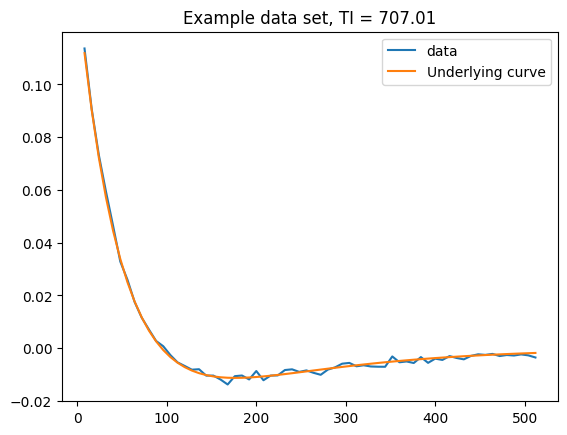

100%|██████████| 25000000/25000000 [52:46<00:00, 7896.37it/s] 


In [27]:
np.random.seed(0)
underlying_4p = S_biX_4p(TE_series, d1, d2, T21, T22)
data_4p = add_noise(noise_sd, underlying_4p)

d1_init = d1
d2_init = di_sum - d1_init
param_init_4p = (d1_init, d2_init, T21, T22)

plt.plot(TE_series, data_4p, label='data')
plt.plot(TE_series, underlying_4p, label='Underlying curve')
plt.title('Example data set, TI = %s' % (np.round(TI_poi,3)))
plt.legend()
plt.show()

joint_pdf_4p = pdf_np_4_param(data_4p, noise_sd)

#Save metropolis steps as estimates_4P, an (n_iterations x 4) matrix
estimates_4p = metropolis_4p(joint_pdf_4p, prior_4p, transition_model_d_constrained,
                    param_init_4p, n_iter_m4p, data_4p, acceptance_4p, verbose=True)

d1 estimate: 0.11238909906260175
d2 estimate: -0.12766180392822568
T21 estimate: 54.08916639078327
T22 estimate: 147.28939730659687


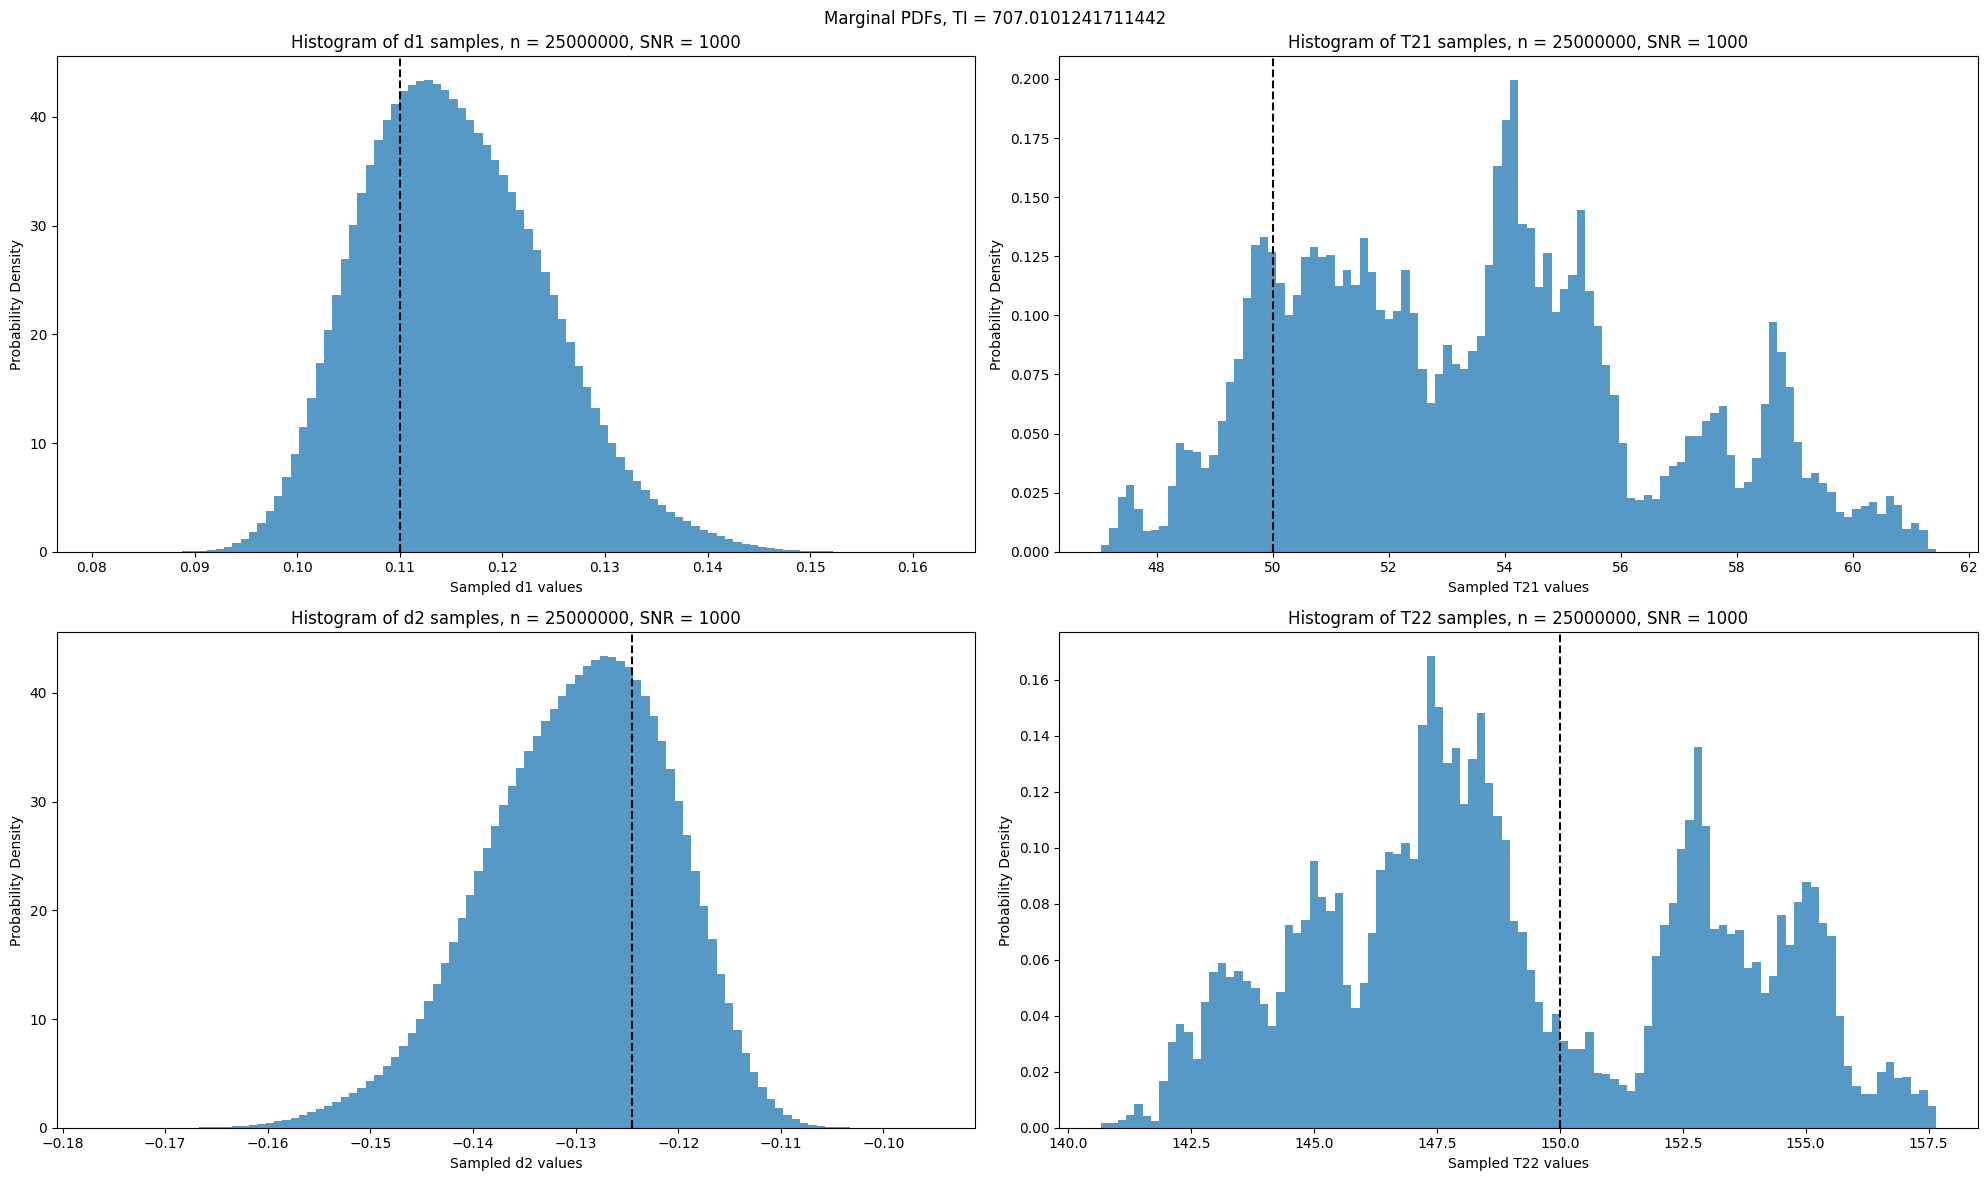

In [33]:
# print('Max of joint pdf at:', max_joint_pdf(estimates_4p)*np.array([1,1,t_norm,t_norm,t_norm,t_norm]))
fig, ax = plt.subplots(2,2,figsize = (20, 12), tight_layout=True)
fig.suptitle(f'Marginal PDFs, TI = {TI_poi}')
c1n, c1bins, c1patches = ax[0,0].hist(estimates_4p[:,0], 100, density=True, alpha=0.75)
c1_estimate = c1bins[c1n.argmax()]
print('d1 estimate:', c1_estimate)
#ax[0,0].plot(c1_set, c1_function/integrate.simpson(c1_function, c1_set), label='Simpson Integration')
ax[0,0].set_xlabel('Sampled d1 values')
ax[0,0].set_ylabel('Probability Density')
ax[0,0].axvline(x = d1, ls = '--', color = 'k', label = 'true d1')
ax[0,0].set_title('Histogram of d1 samples, n = %s, SNR = %s' % (n_iter_m4p, SNR))

c2n, c2bins, c2patches = ax[1,0].hist(estimates_4p[:,1], 100, density=True, alpha=0.75)
c2_estimate = c2bins[c2n.argmax()]
print('d2 estimate:', c2_estimate)
ax[1,0].set_xlabel('Sampled d2 values')
ax[1,0].set_ylabel('Probability Density')
ax[1,0].axvline(x = d2, ls = '--', color = 'k', label = 'true d2')
ax[1,0].set_title('Histogram of d2 samples, n = %s, SNR = %s' % (n_iter_m4p, SNR))

T11n, T11bins, T11patches = ax[0,1].hist(estimates_4p[:,2], 100, density=True, alpha=0.75)
T11_estimate = T11bins[T11n.argmax()]
print('T21 estimate:', T11_estimate)
ax[0,1].set_xlabel('Sampled T21 values')
ax[0,1].set_ylabel('Probability Density')
ax[0,1].axvline(x = T21, ls = '--', color = 'k', label = 'true T21')
ax[0,1].set_title('Histogram of T21 samples, n = %s, SNR = %s' % (n_iter_m4p, SNR))

T12n, T12bins, T12patches = ax[1,1].hist(estimates_4p[:,3], 100, density=True, alpha=0.75)
T12_estimate = T12bins[T12n.argmax()]
print('T22 estimate:', T12_estimate)
ax[1,1].set_xlabel('Sampled T22 values')
ax[1,1].set_ylabel('Probability Density')
ax[1,1].axvline(x = T22, ls = '--', color = 'k', label = 'true T22')
ax[1,1].set_title('Histogram of T22 samples, n = %s, SNR = %s' % (n_iter_m4p, SNR))

plt.show()

In [29]:
#This is for if you include the constraint T21 < T22 in the data, but wish to symmetrize the PDF
graphing_data = estimates_4p #dset.copy()
gd_mirror = np.zeros(graphing_data.shape)
gd_mirror[:,0] = graphing_data[:,1]
gd_mirror[:,1] = graphing_data[:,0]
gd_mirror[:,2] = graphing_data[:,3]
gd_mirror[:,3] = graphing_data[:,2]
graphing_data = np.append(graphing_data, gd_mirror, axis=0)

d1 estimate: 0.1959311403658634
d2 estimate: 0.1959311403658634
T21 estimate: 53.70509115606937
T22 estimate: 53.70509115606937


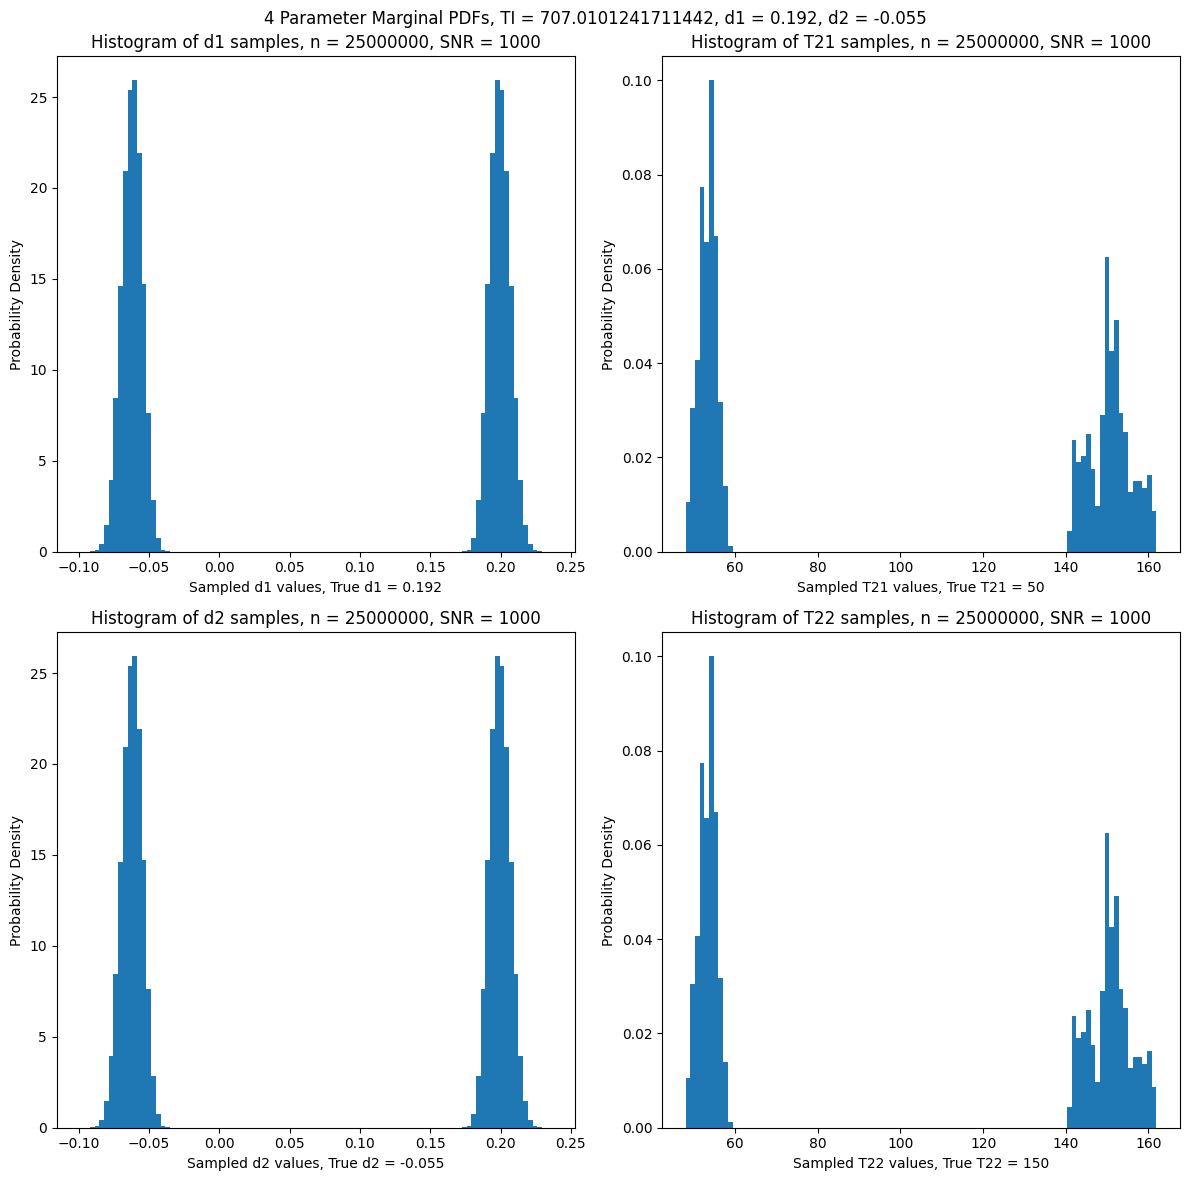

In [30]:
#Visualizes the marginal PDFs of the 4 variables
fig, ax = plt.subplots(2,2,figsize = (12, 12), tight_layout=True)
fig.suptitle('4 Parameter Marginal PDFs, TI = %s, d1 = %s, d2 = %s'%(TI_poi,round(d1, 3), round(d2,3)))
d1n, d1bins, d1patches = ax[0,0].hist(graphing_data[:,0], 100, density=True)
d1_estimate = d1bins[d1n.argmax()]
print('d1 estimate:', d1_estimate)
ax[0,0].set_xlabel('Sampled d1 values, True d1 = %s'%round(d1, 3))
ax[0,0].set_ylabel('Probability Density')
ax[0,0].set_title('Histogram of d1 samples, n = %s, SNR = %s' % (n_iter_m4p, SNR))

d2n, d2bins, d2patches = ax[1,0].hist(graphing_data[:,1], 100, density=True)
d2_estimate = d2bins[d2n.argmax()]
print('d2 estimate:', d2_estimate)
ax[1,0].set_xlabel('Sampled d2 values, True d2 = %s'%round(d2,3))
ax[1,0].set_ylabel('Probability Density')
ax[1,0].set_title('Histogram of d2 samples, n = %s, SNR = %s' % (n_iter_m4p, SNR))

T21n, T21bins, T21patches = ax[0,1].hist(graphing_data[:,2], 100, density=True)
T21_estimate = T21bins[T21n.argmax()]
print('T21 estimate:', T21_estimate)
#ax[0,1].set_ylim([0,6])
ax[0,1].set_xlabel('Sampled T21 values, True T21 = %s'%(T21))
ax[0,1].set_ylabel('Probability Density')
ax[0,1].set_title('Histogram of T21 samples, n = %s, SNR = %s' % (n_iter_m4p, SNR))

T22n, T22bins, T22patches = ax[1,1].hist(graphing_data[:,3], 100, density=True)
T22_estimate = T22bins[T22n.argmax()]
print('T22 estimate:', T22_estimate)
#ax[1,1].set_ylim([0,0.001])
ax[1,1].set_xlabel('Sampled T22 values, True T22 = %s'%(T22))
ax[1,1].set_ylabel('Probability Density')
ax[1,1].set_title('Histogram of T22 samples, n = %s, SNR = %s' % (n_iter_m4p, SNR))

plt.show()

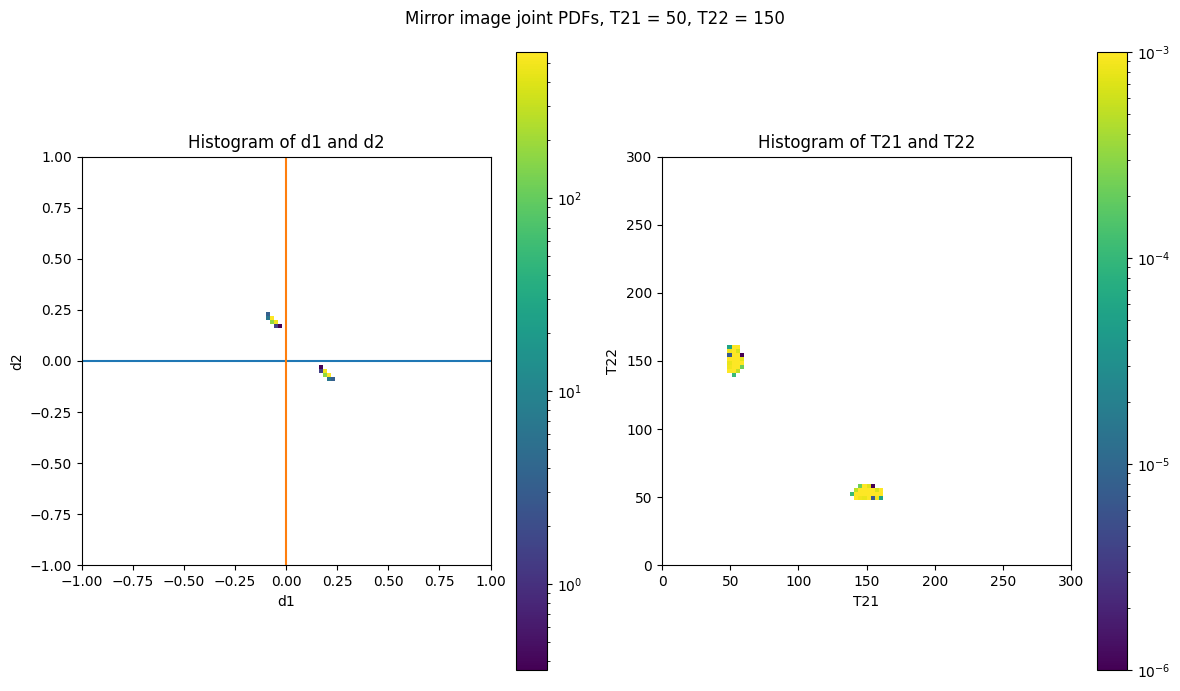

In [31]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,7),tight_layout=True)
fig.suptitle('Mirror image joint PDFs, T21 = %s, T22 = %s'%(T21, T22))
ax1.set_aspect('equal')
ax2.set_aspect('equal')

hh1 = ax1.hist2d(graphing_data[:,0], graphing_data[:,1], 
                 norm=mpl.colors.LogNorm(), bins=100, density=True,range=([-1,1],[-1,1]))
ax1.set_title('Histogram of d1 and d2')
ax1.set_xlabel('d1')
ax1.set_ylabel('d2')
ax1.plot(np.linspace(-1,1,10), [0]*10)
ax1.plot([0]*10, np.linspace(-1,1,10))

hh2 = ax2.hist2d(graphing_data[:,2], graphing_data[:,3], 
                 norm=mpl.colors.LogNorm(vmin=10**(-6),vmax=10**(-3)), bins=100, density=True,range=([0,300],[0,300]))
ax2.set_title('Histogram of T21 and T22')
ax2.set_xlabel('T21')
ax2.set_ylabel('T22')

fig.colorbar(hh1[3], ax=ax1)
fig.colorbar(hh2[3], ax=ax2)

plt.show()

### Iterate Through TI Values

In [32]:
standard_array = np.arange(-nullRadius,nullRadius+0.01,nullResolution)
TI1_array = np.floor(TI1star) + standard_array

hold_array = np.zeros((np.size(TI1_array), n_iter_m4p, 4))

for TI_idx in trange(len(TI1_array)):
    iTI = TI1_array[TI_idx]
    #Iterate through the set of TI values, looking for the null points in the data
    d1 = c1*(1-2*np.exp(-iTI/T11))
    d2 = c2*(1-2*np.exp(-iTI/T12))
    di_sum = d1+d2
    #Generate the data and calculate the Bayesian Posterior PDF
    np.random.seed(0)
    underlying_4p = S_biX_4p(TE_series, d1, d2, T21, T22)
    data_4p = add_noise(noise_sd, underlying_4p)

    joint_pdf_4p = pdf_np_4_param(data_4p, noise_sd)
    #Set the initial values for the burnin times and run metropolis on the PDF
    d1_init = d1
    d2_init = di_sum - d1_init
    burnin_init_4p = (d1_init, d2_init, T21, T22)

    estimates_4p = metropolis_4p(joint_pdf_4p,prior_4p,transition_model_d_constrained, 
                            burnin_init_4p, n_iter_m4p, data_4p, acceptance_4p, verbose=False)

    hold_array[TI_idx,:,:] = estimates_4p

100%|██████████| 13/13 [8:28:44<00:00, 2348.06s/it]  


d1 estimate: -0.15503350797533166
d2 estimate: -0.2904844624446274
T21 estimate: 52.46567083417026
T22 estimate: 152.33722341405615


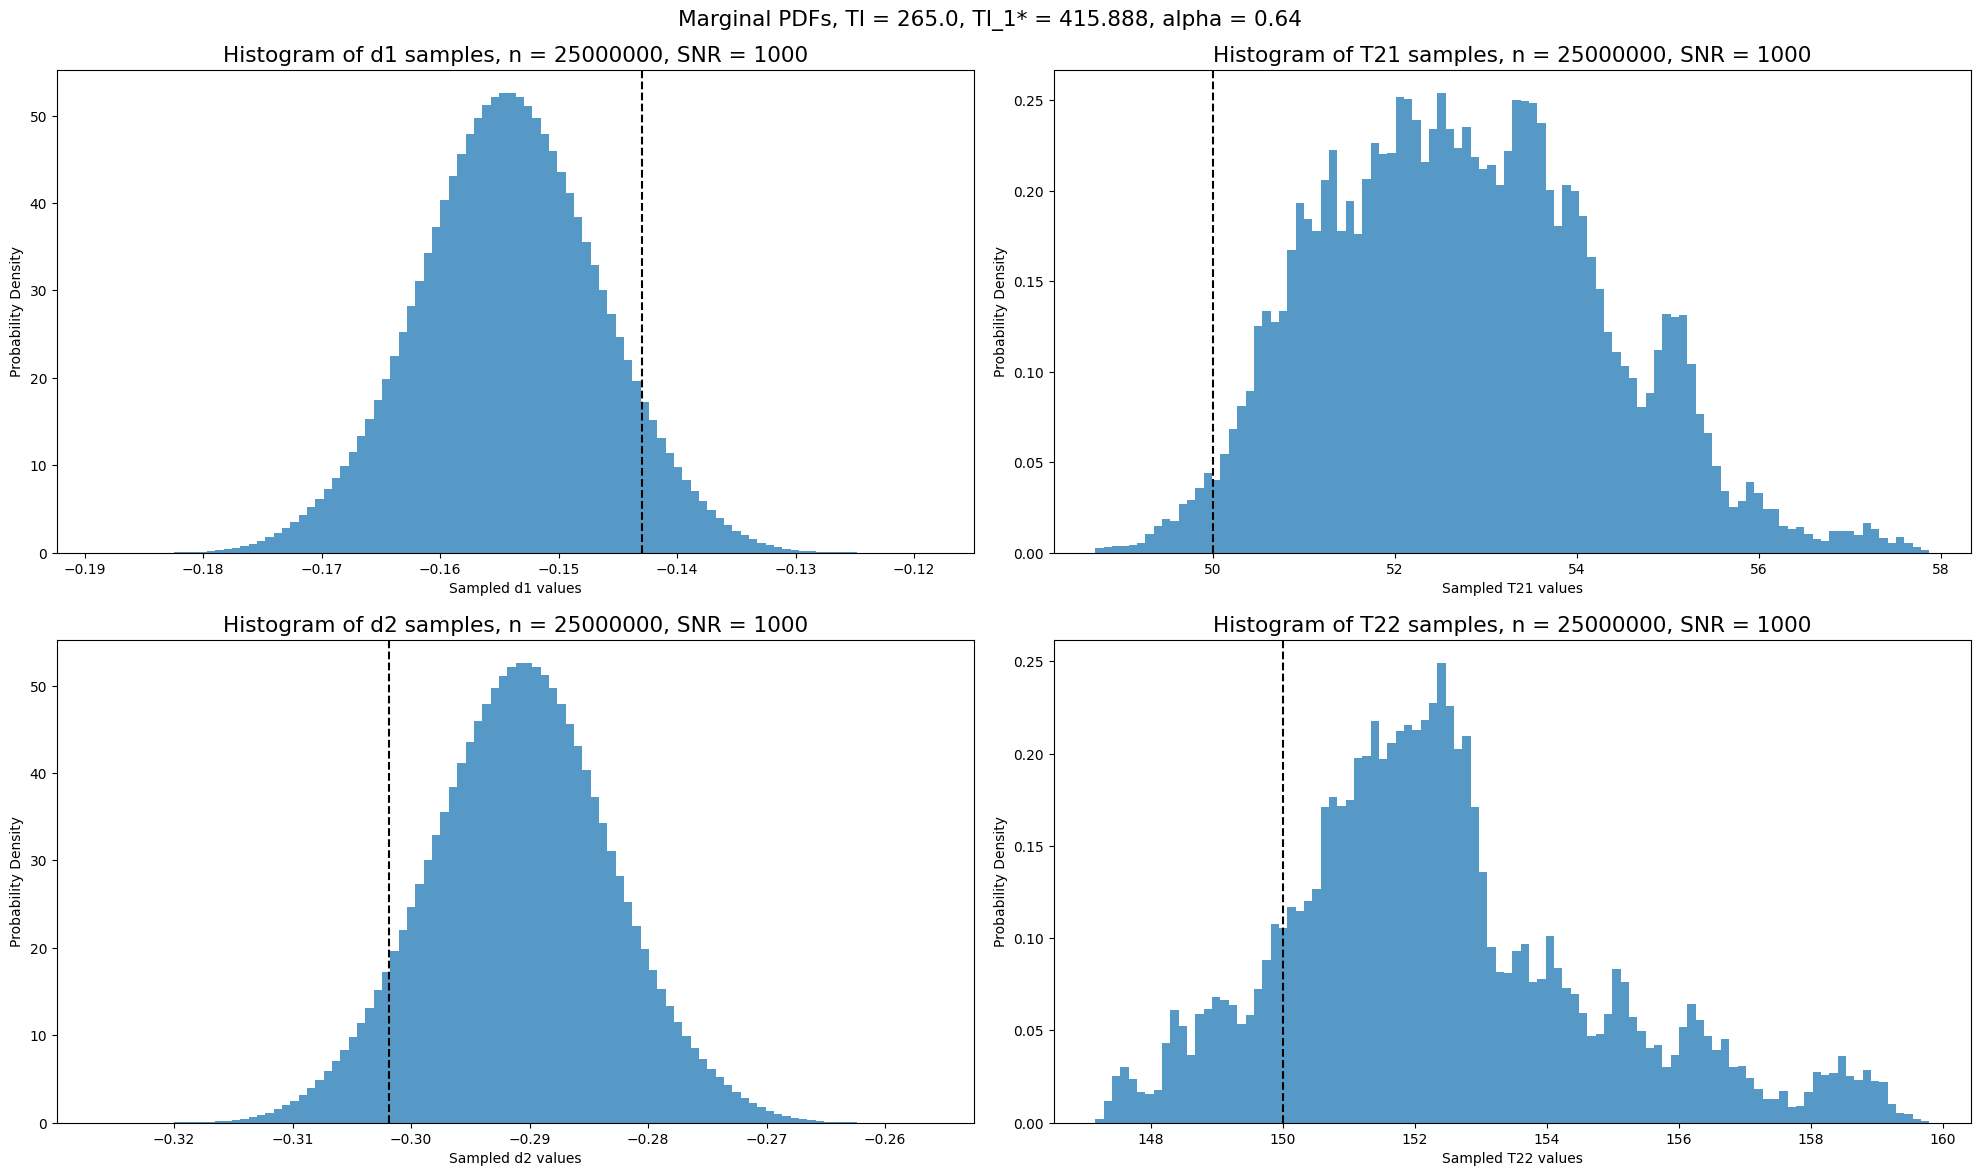

d1 estimate: -0.12388195566529603
d2 estimate: -0.27890187441958847
T21 estimate: 58.99218366132971
T22 estimate: 149.50234018212802


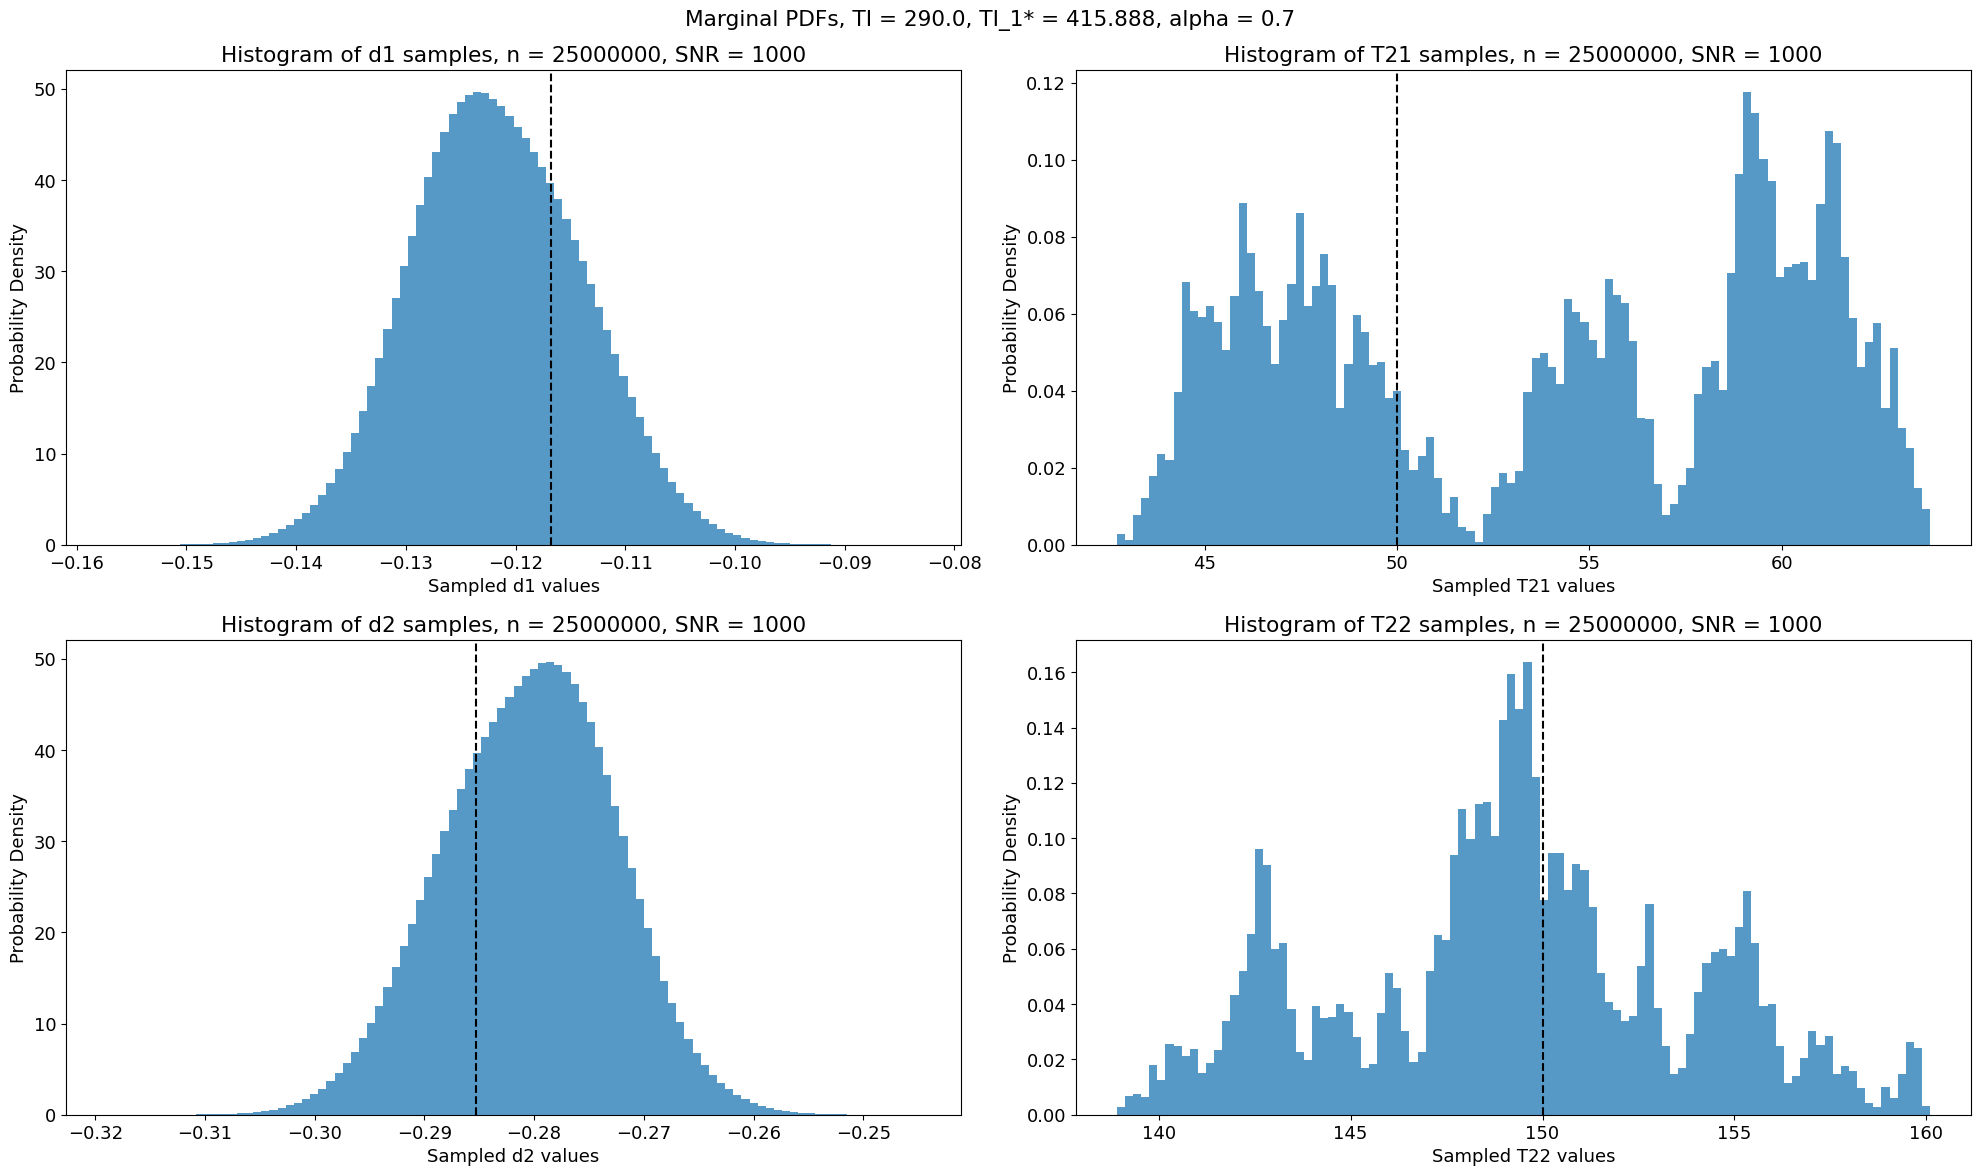

d1 estimate: -0.10297343625465527
d2 estimate: -0.25847106745771237
T21 estimate: 51.69428627292738
T22 estimate: 153.44094841832074


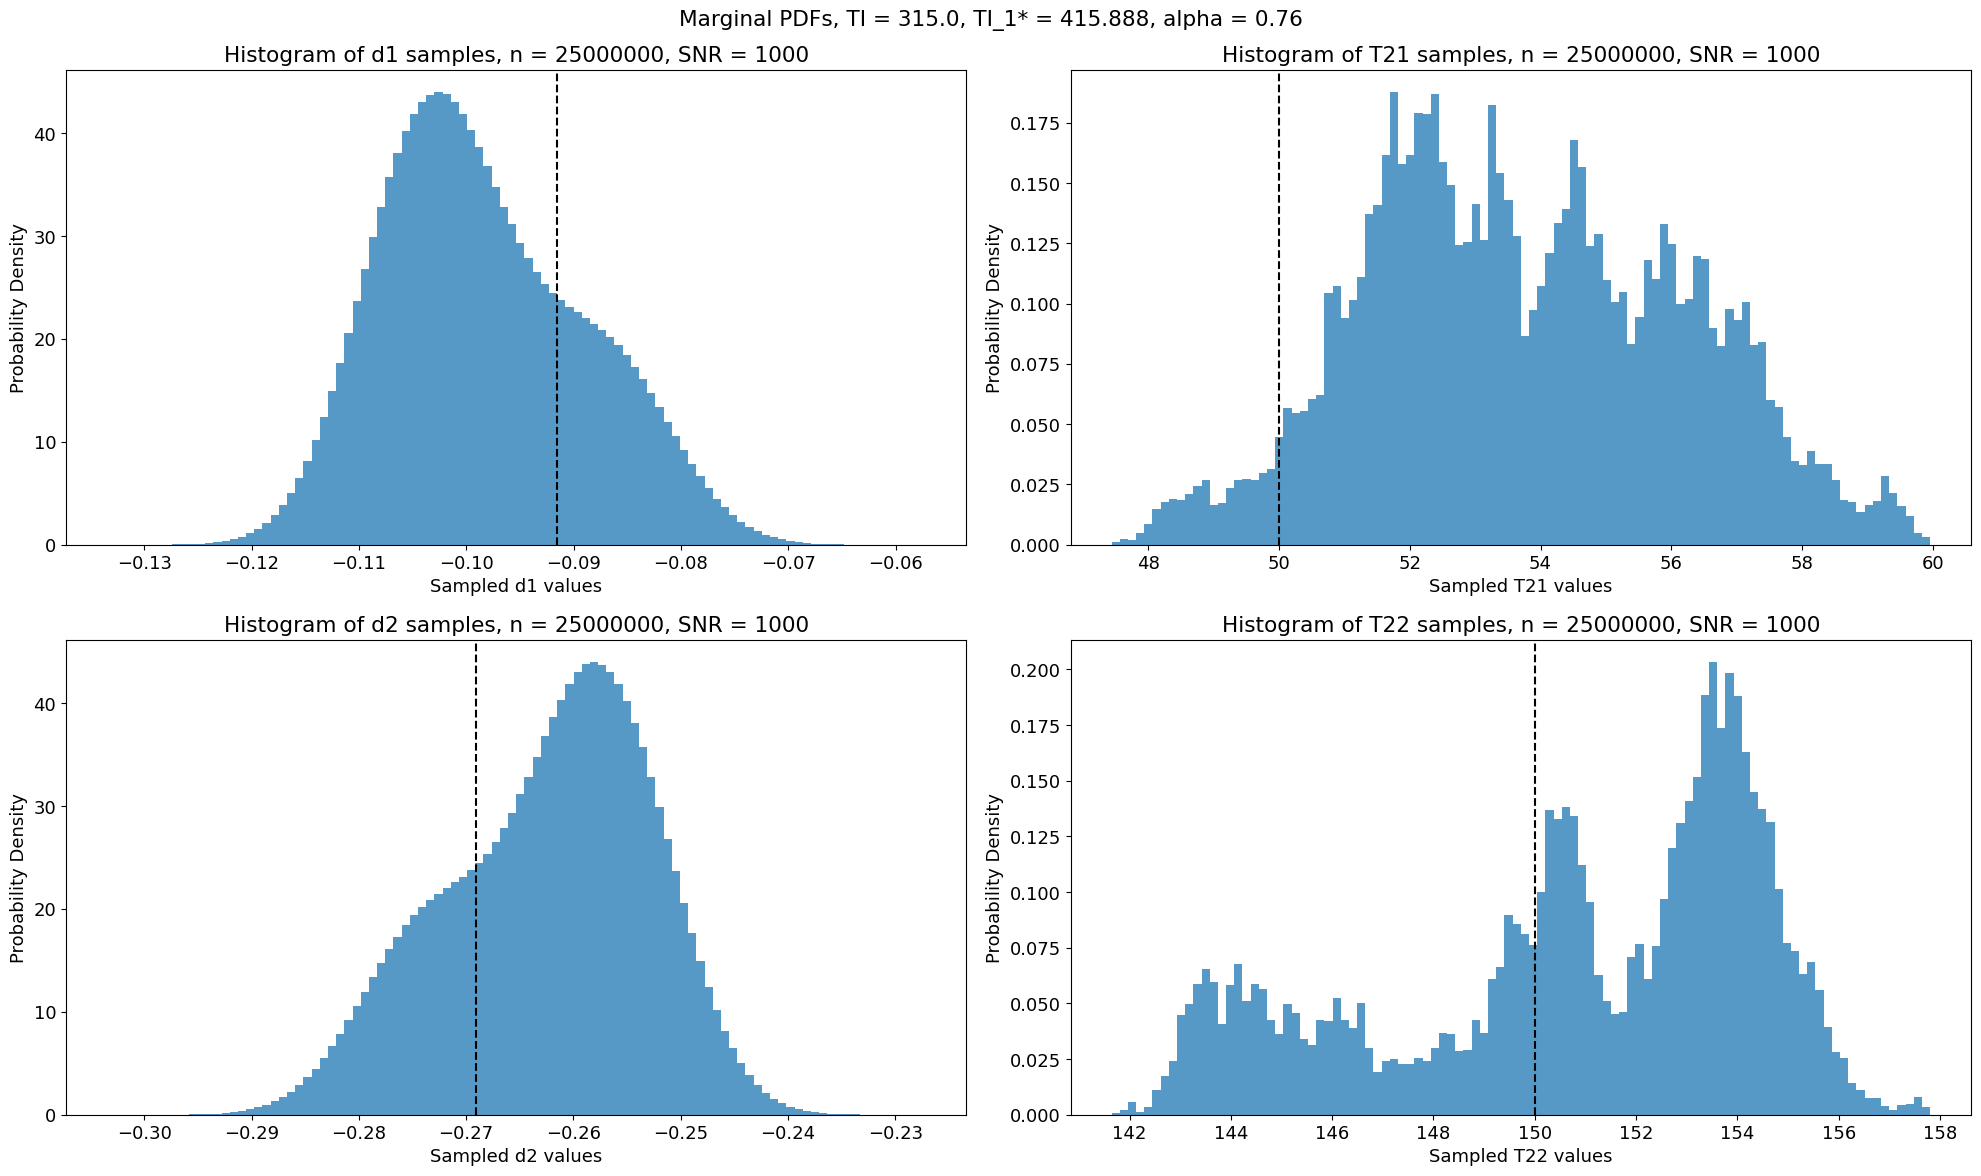

d1 estimate: -0.073872428726658
d2 estimate: -0.24756298052357154
T21 estimate: 49.388542952927644
T22 estimate: 152.99733746203637


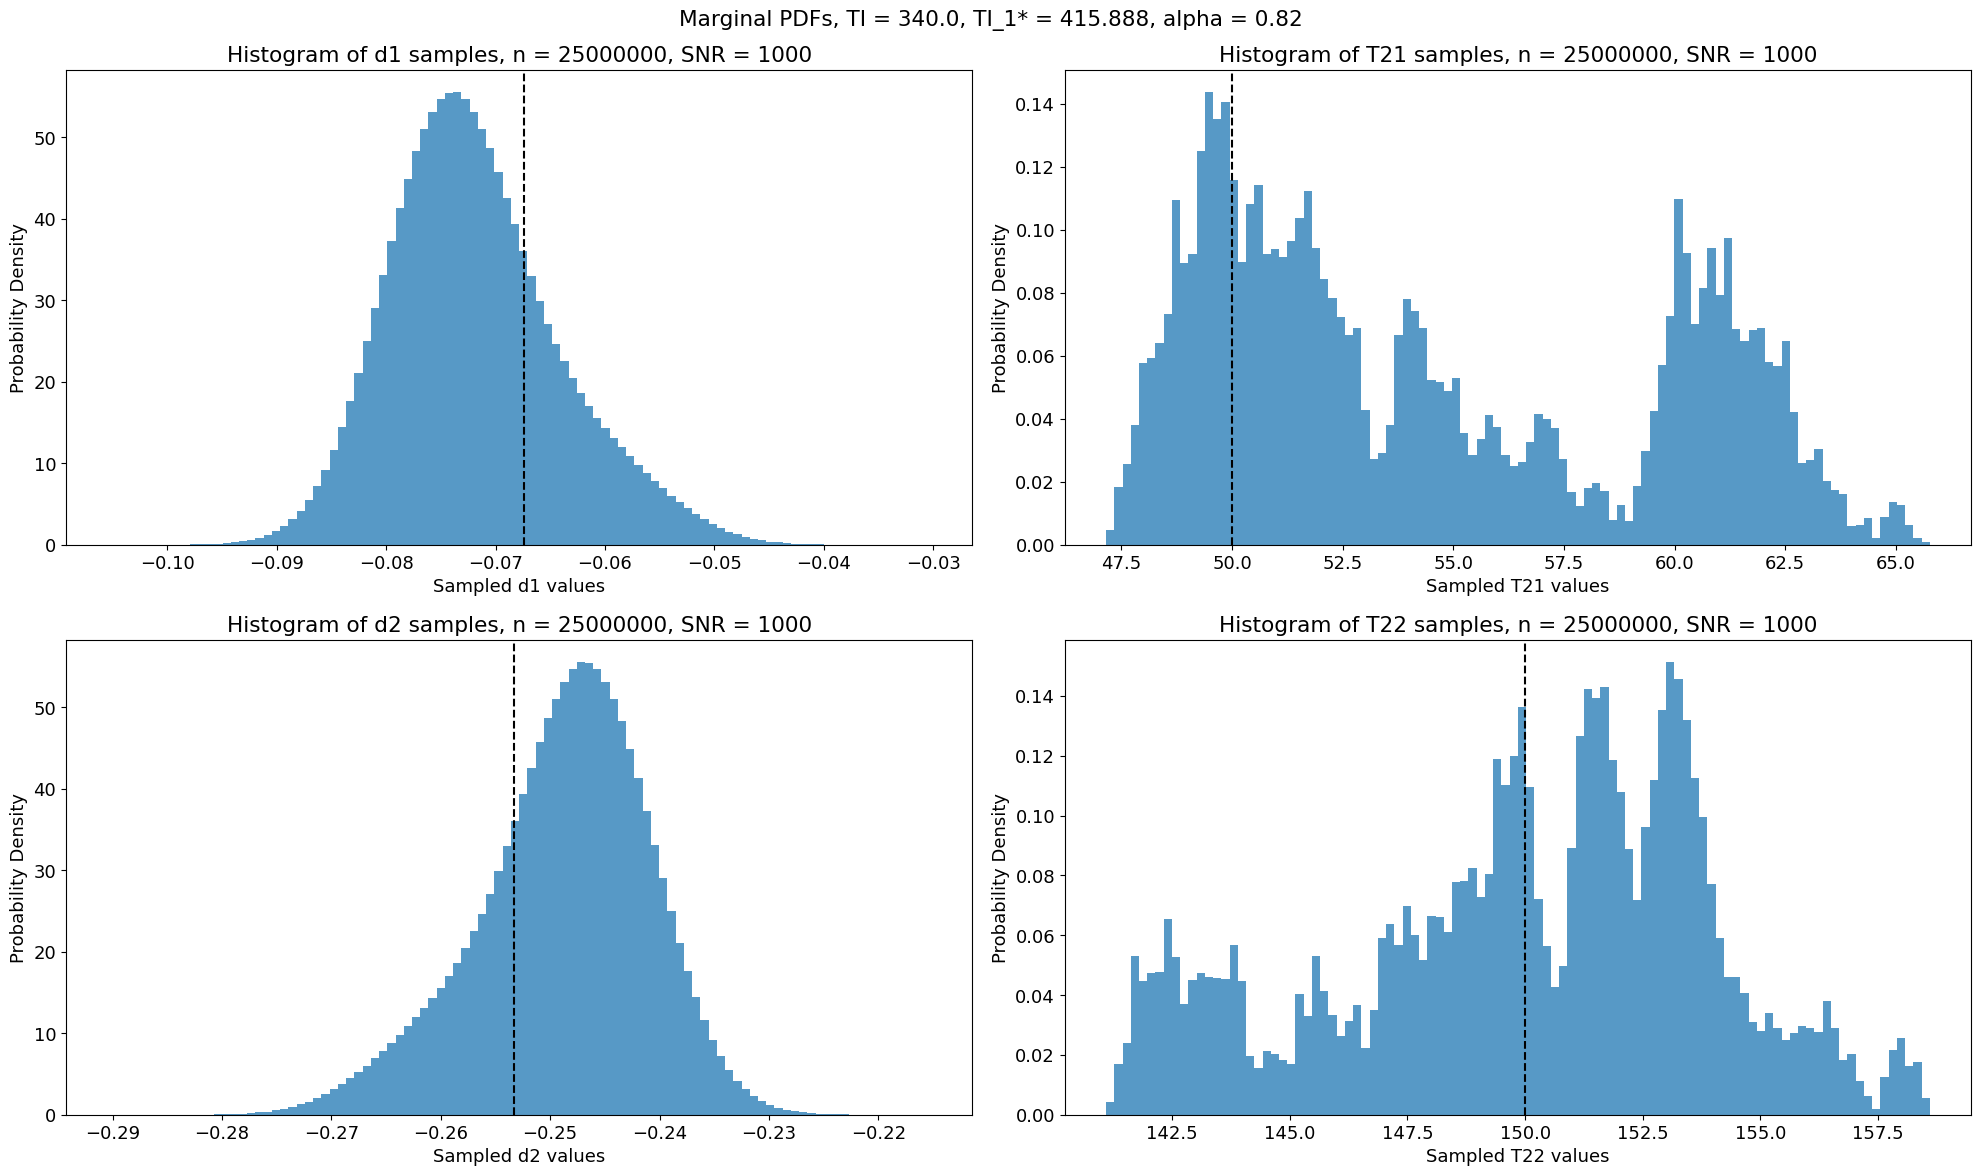

d1 estimate: -0.047799936086563126
d2 estimate: -0.23490401711995706
T21 estimate: 56.63067013270857
T22 estimate: 148.96623609927693


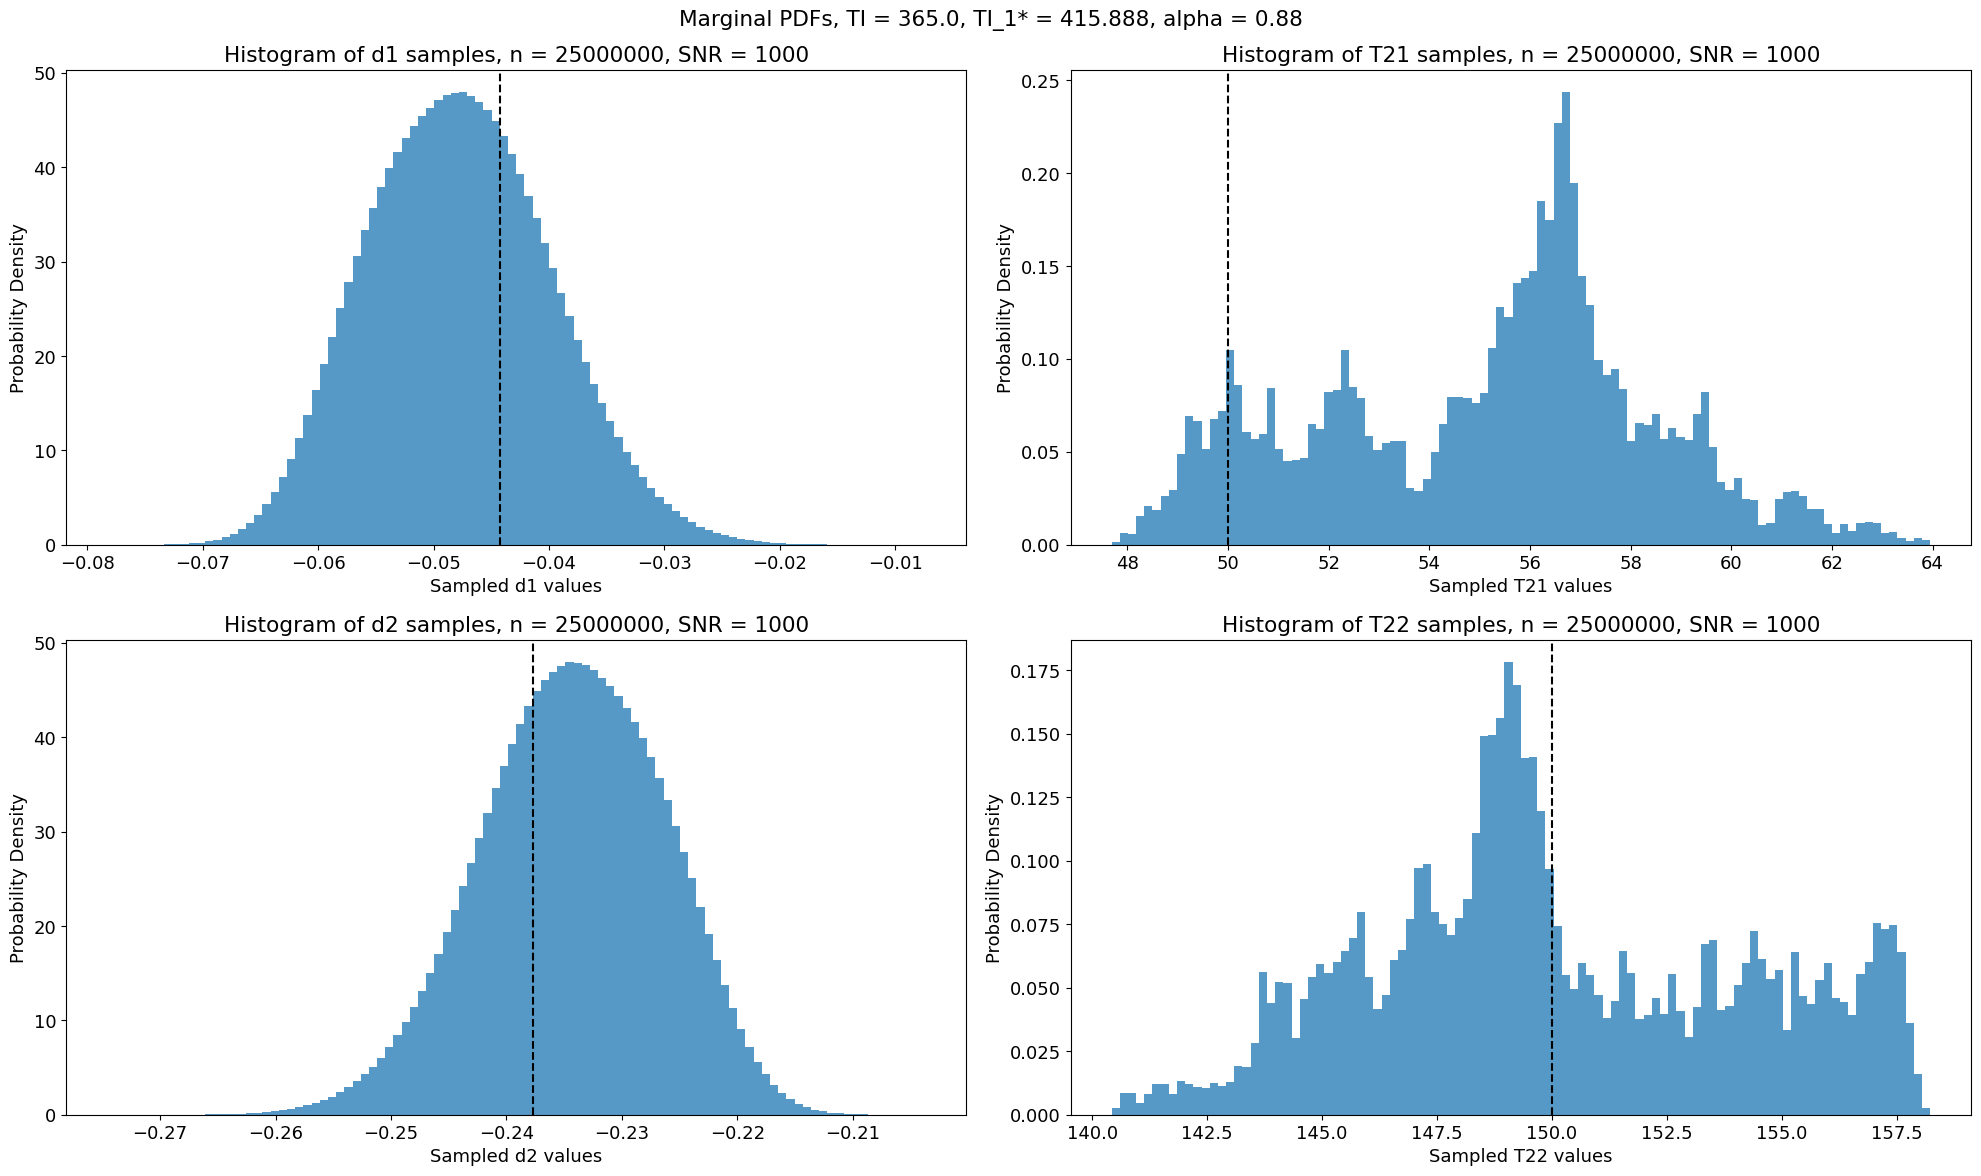

d1 estimate: -0.019276994856547408
d2 estimate: -0.22591666819086023
T21 estimate: 55.9104434329267
T22 estimate: 149.03095327290472


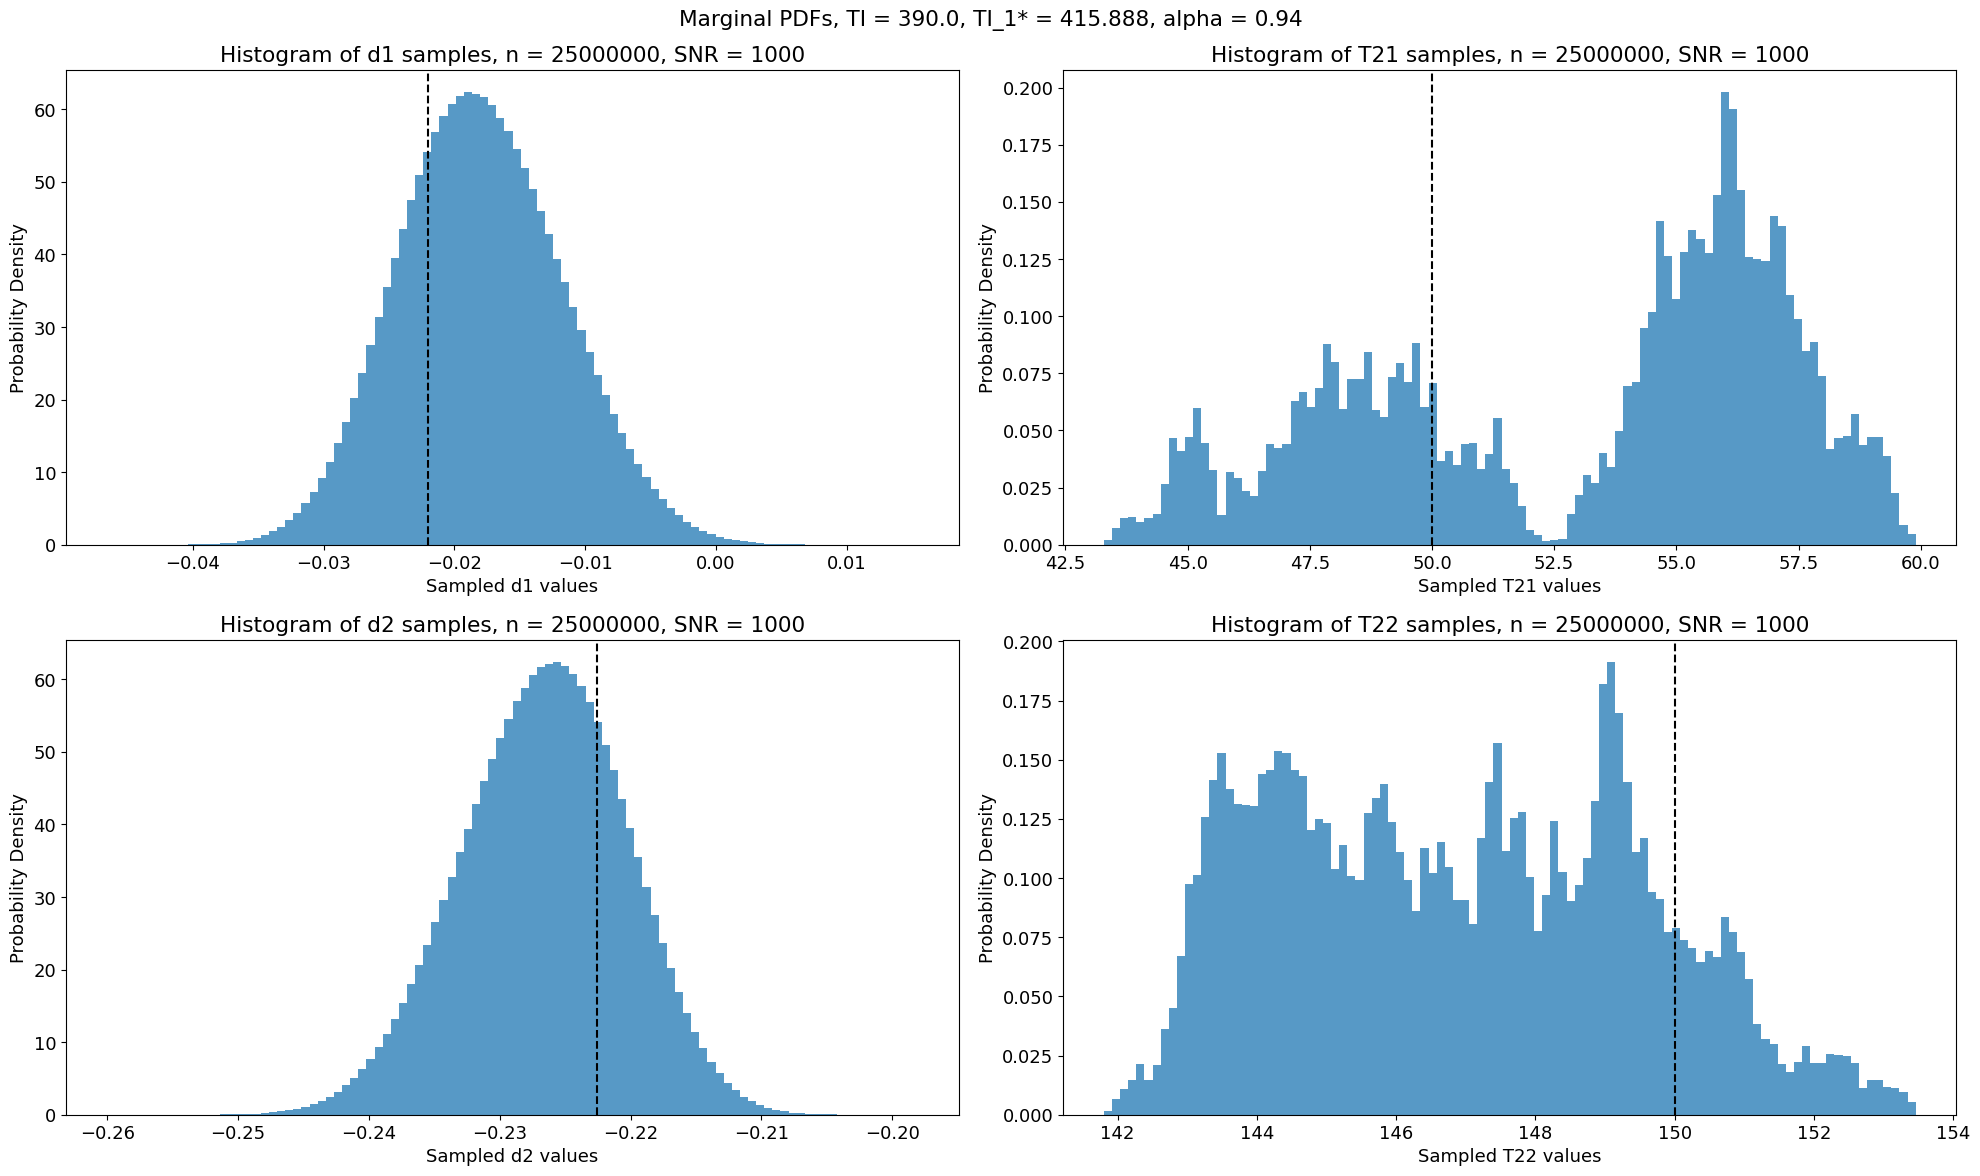

d1 estimate: -0.0033292053541216574
d2 estimate: -0.2056749839753218
T21 estimate: 55.54584137384644
T22 estimate: 148.24298117124948


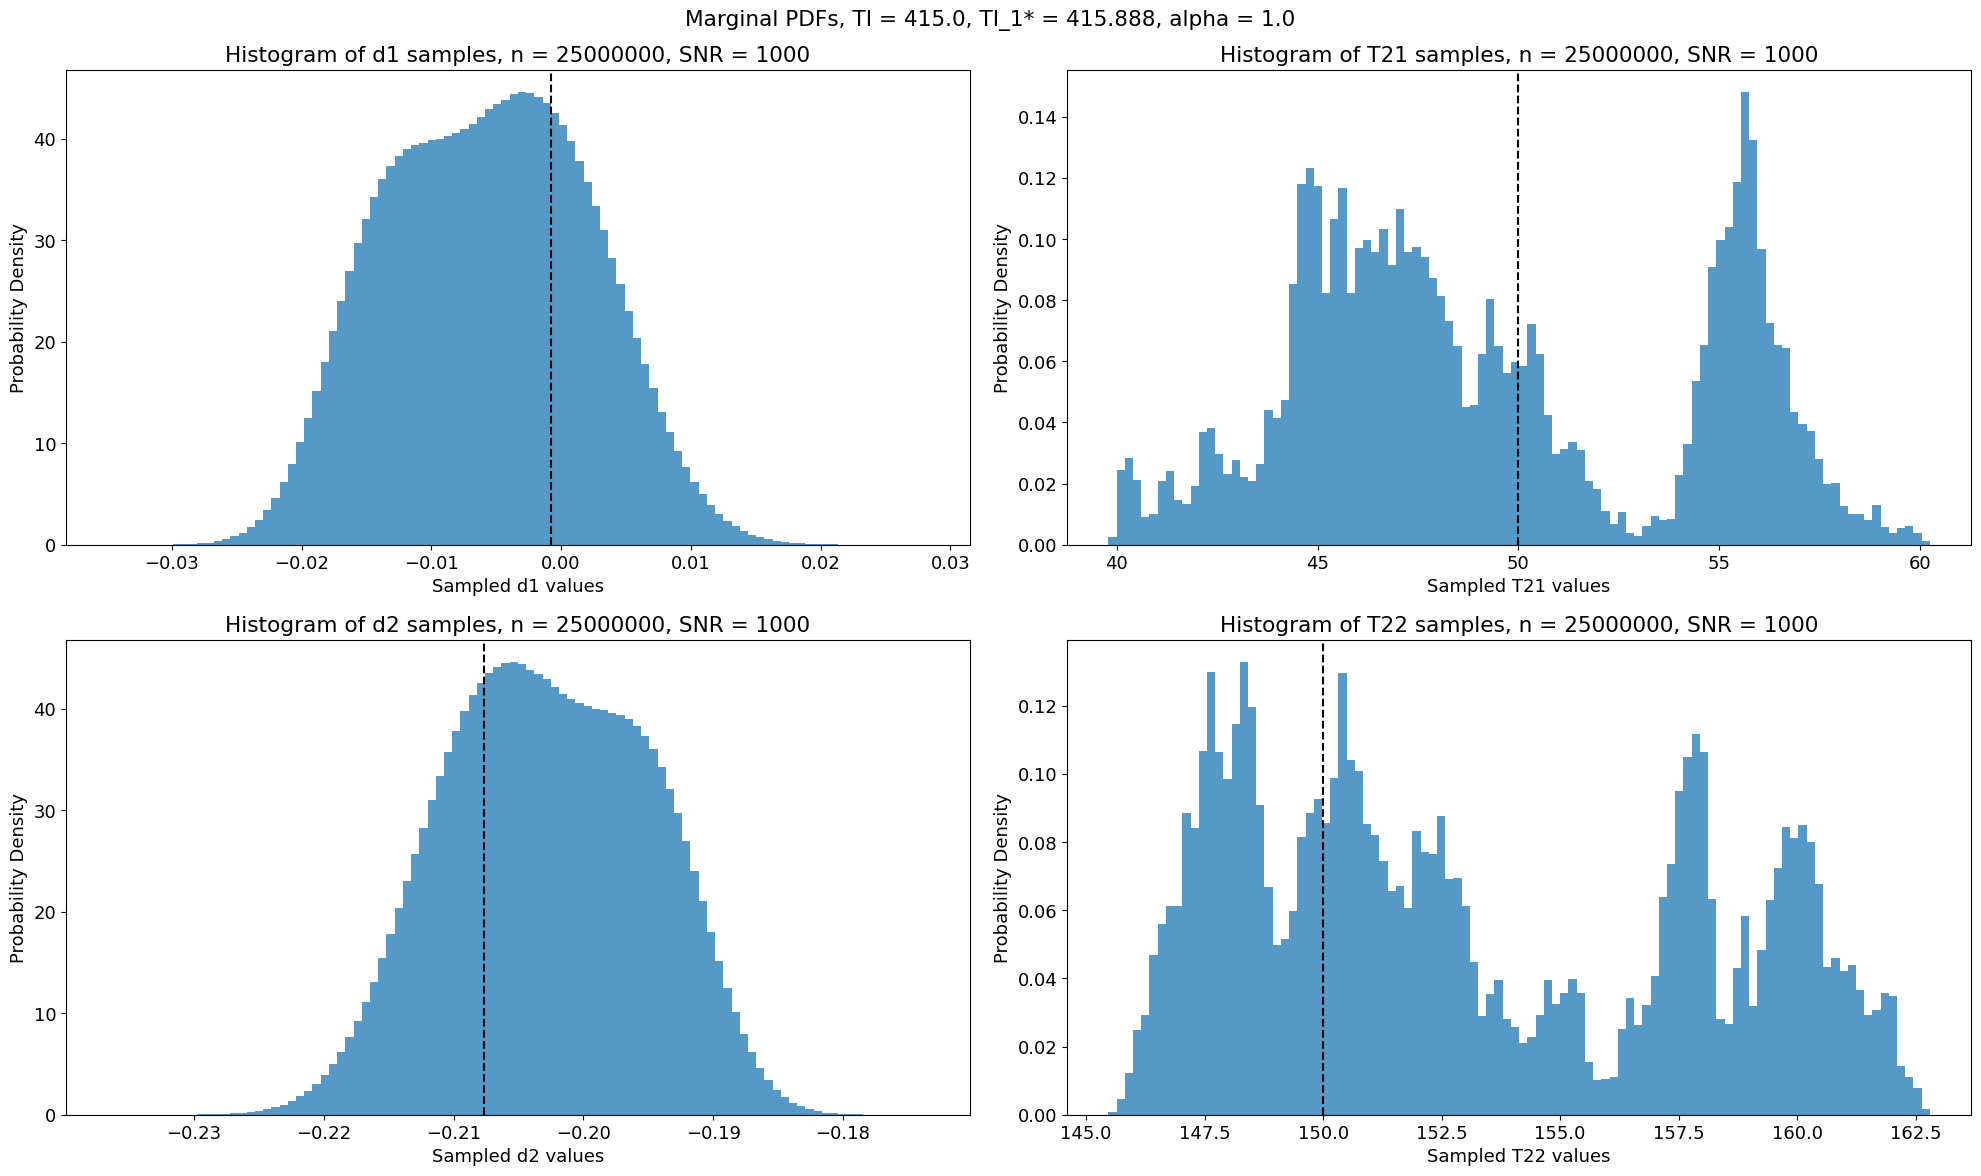

d1 estimate: 0.01947521227819487
d2 estimate: -0.19388552204946802
T21 estimate: 52.15998822838927
T22 estimate: 149.09661702337561


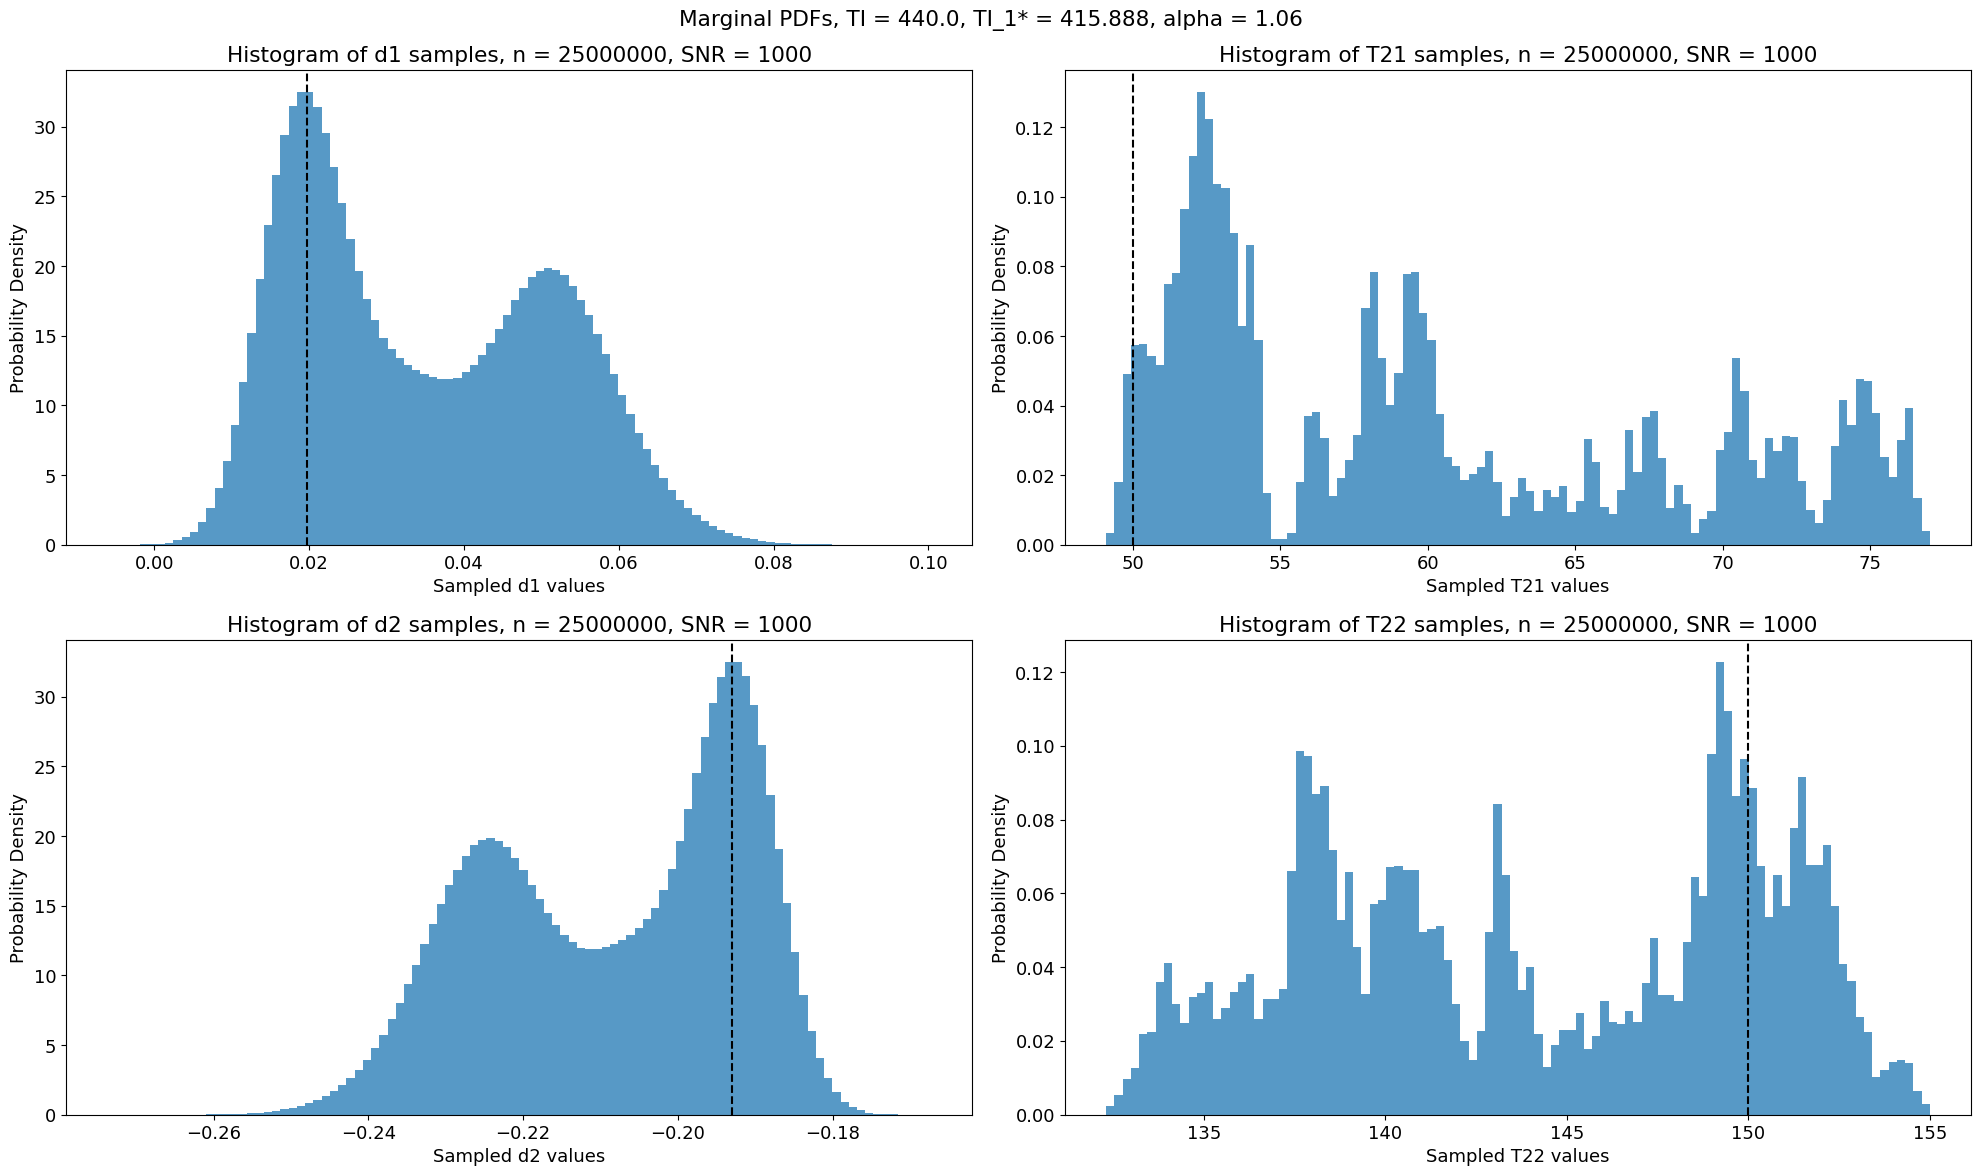

d1 estimate: 0.03887936476792381
d2 estimate: -0.17905006192276382
T21 estimate: 58.00944058769057
T22 estimate: 151.70677949506978


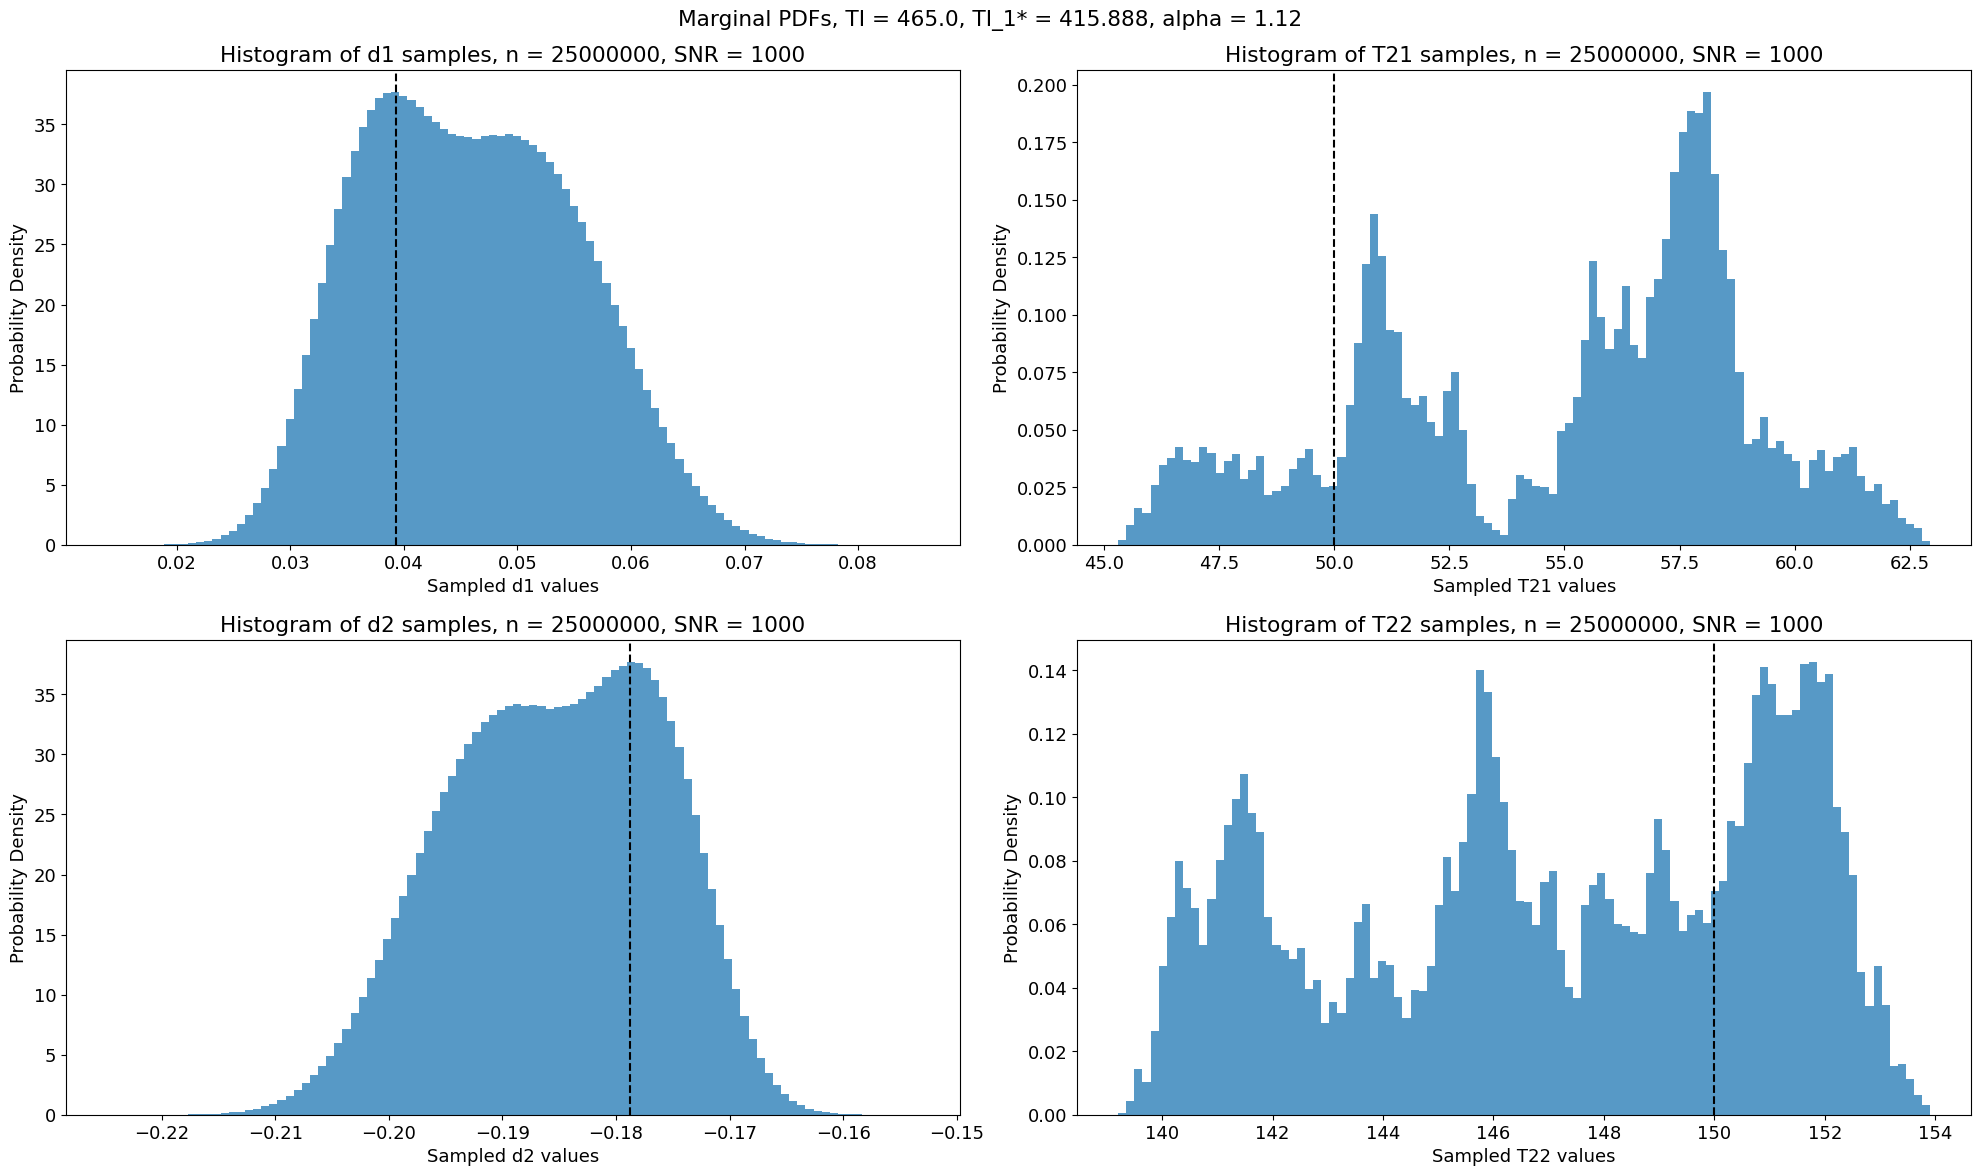

d1 estimate: 0.057223104515930184
d2 estimate: -0.16466603849209172
T21 estimate: 56.10181144302795
T22 estimate: 153.35104476782476


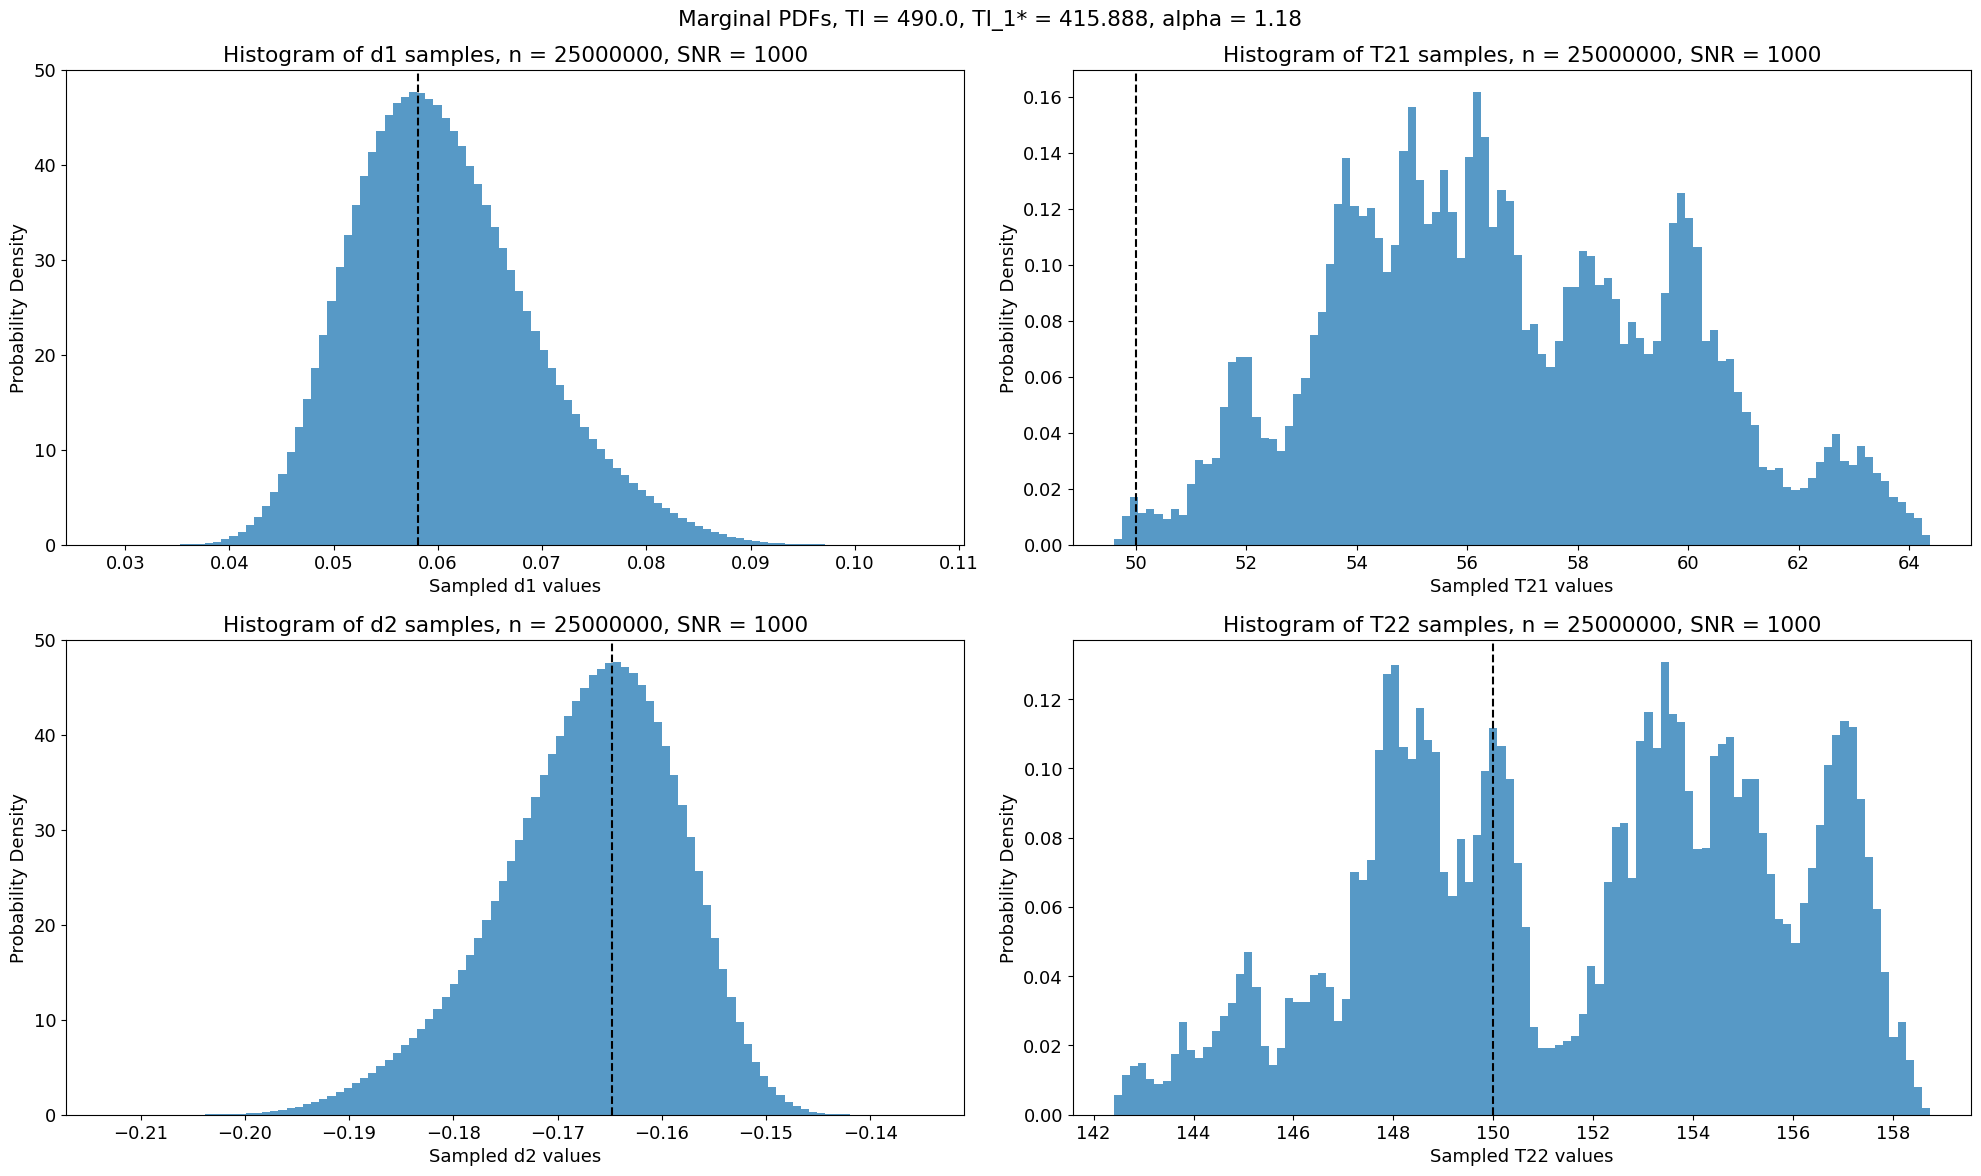

d1 estimate: 0.06943033633069565
d2 estimate: -0.144932515768242
T21 estimate: 51.57329114837238
T22 estimate: 156.8624916077882


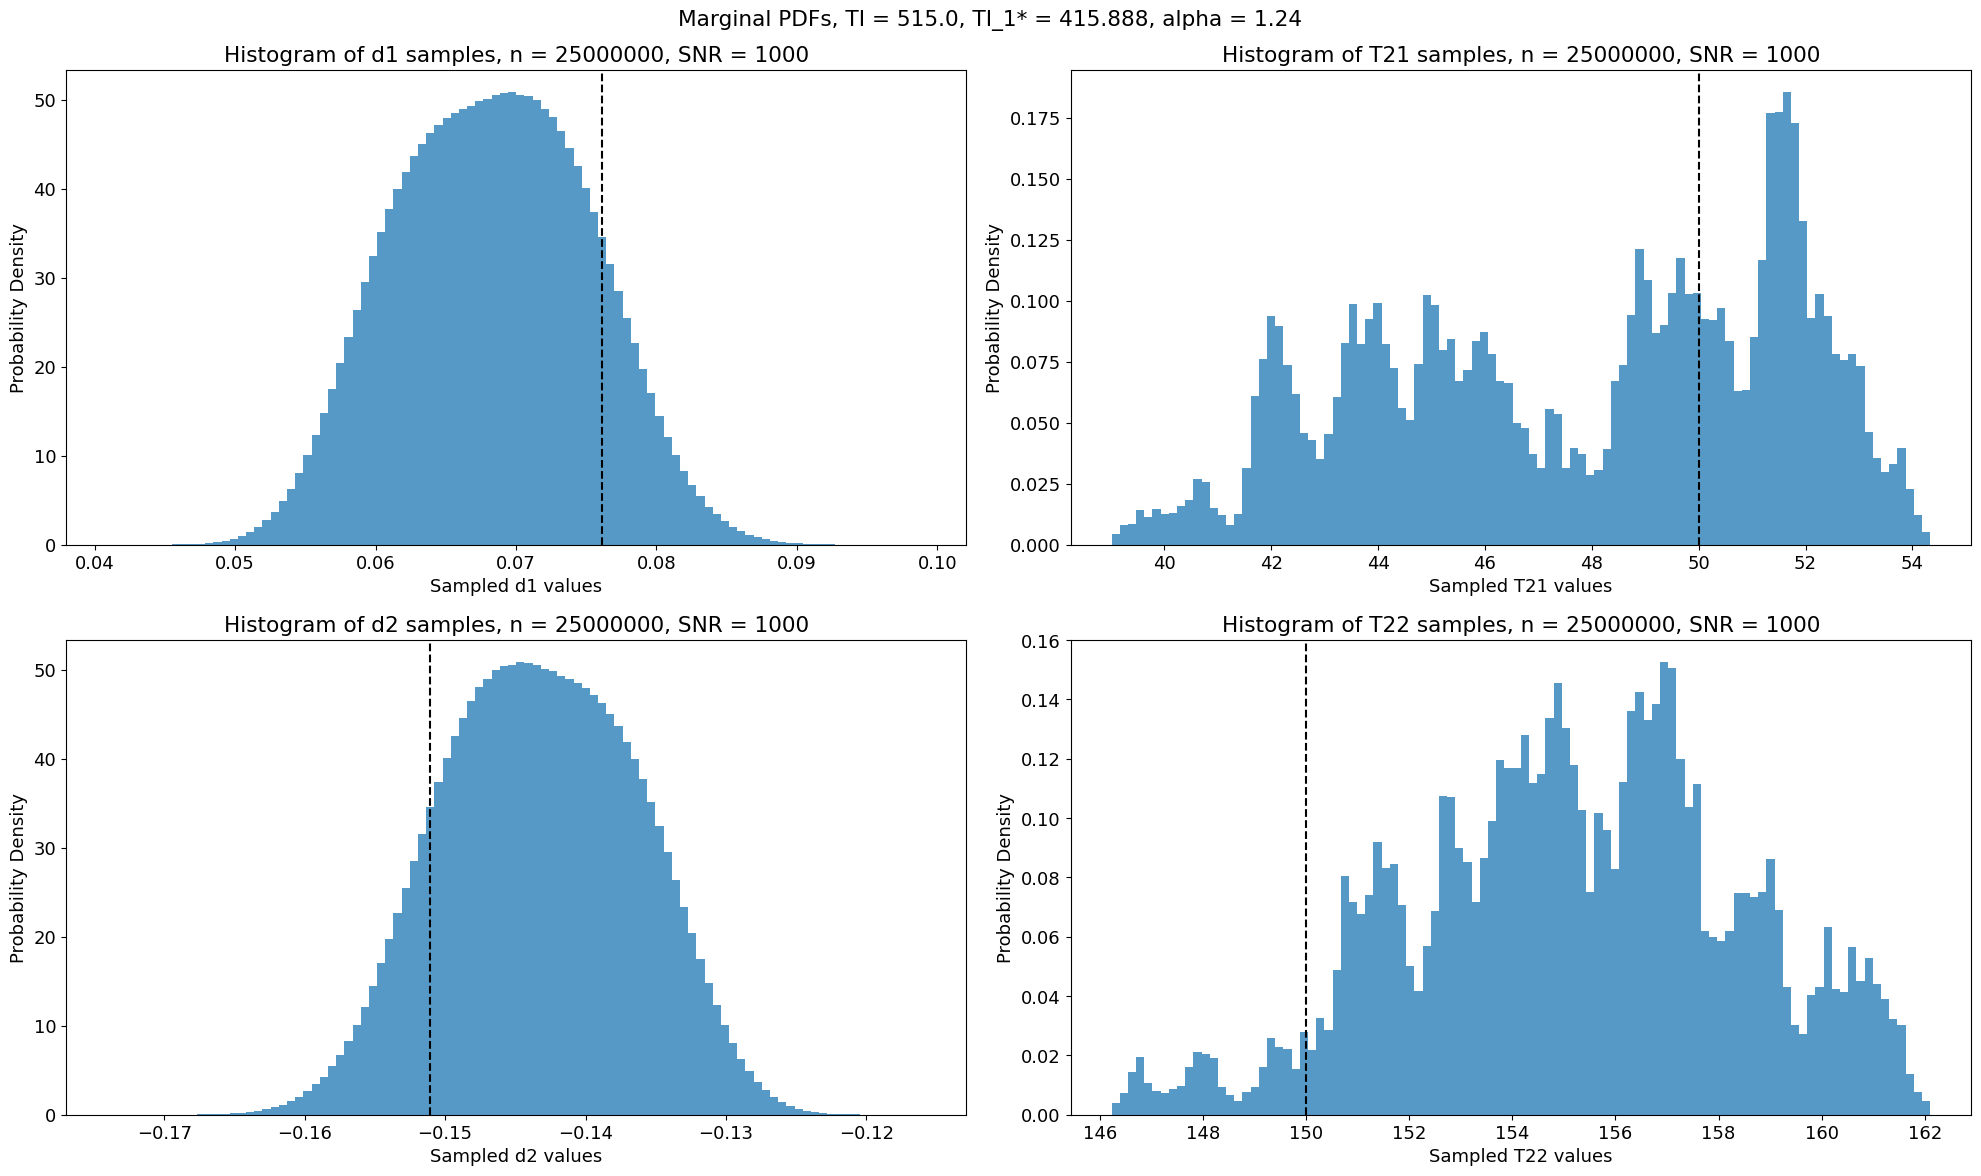

d1 estimate: 0.08997638766429732
d2 estimate: -0.13502992957802035
T21 estimate: 54.148440344019065
T22 estimate: 155.43910875689932


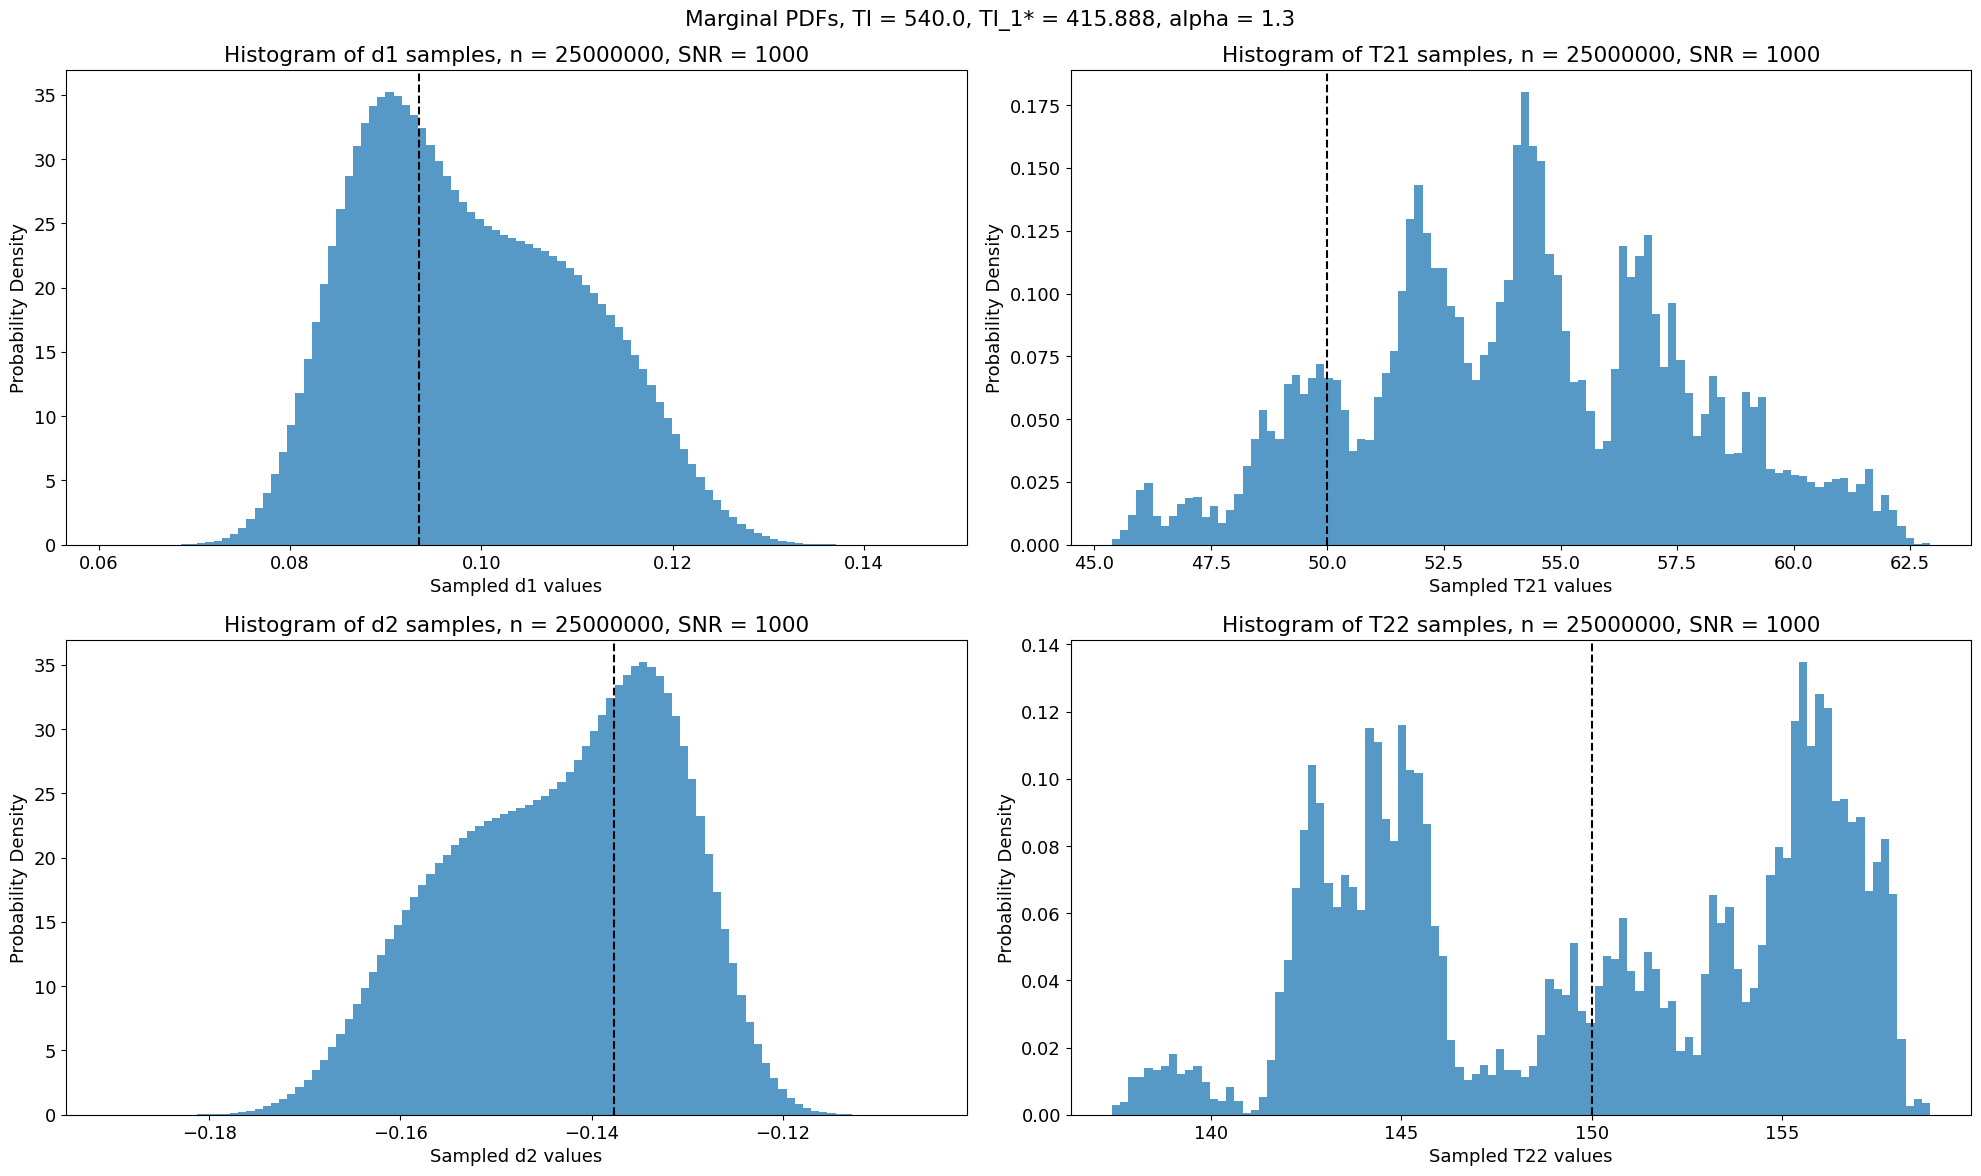

d1 estimate: 0.11238909906260175
d2 estimate: -0.12766180392822568
T21 estimate: 54.08916639078327
T22 estimate: 147.28939730659687


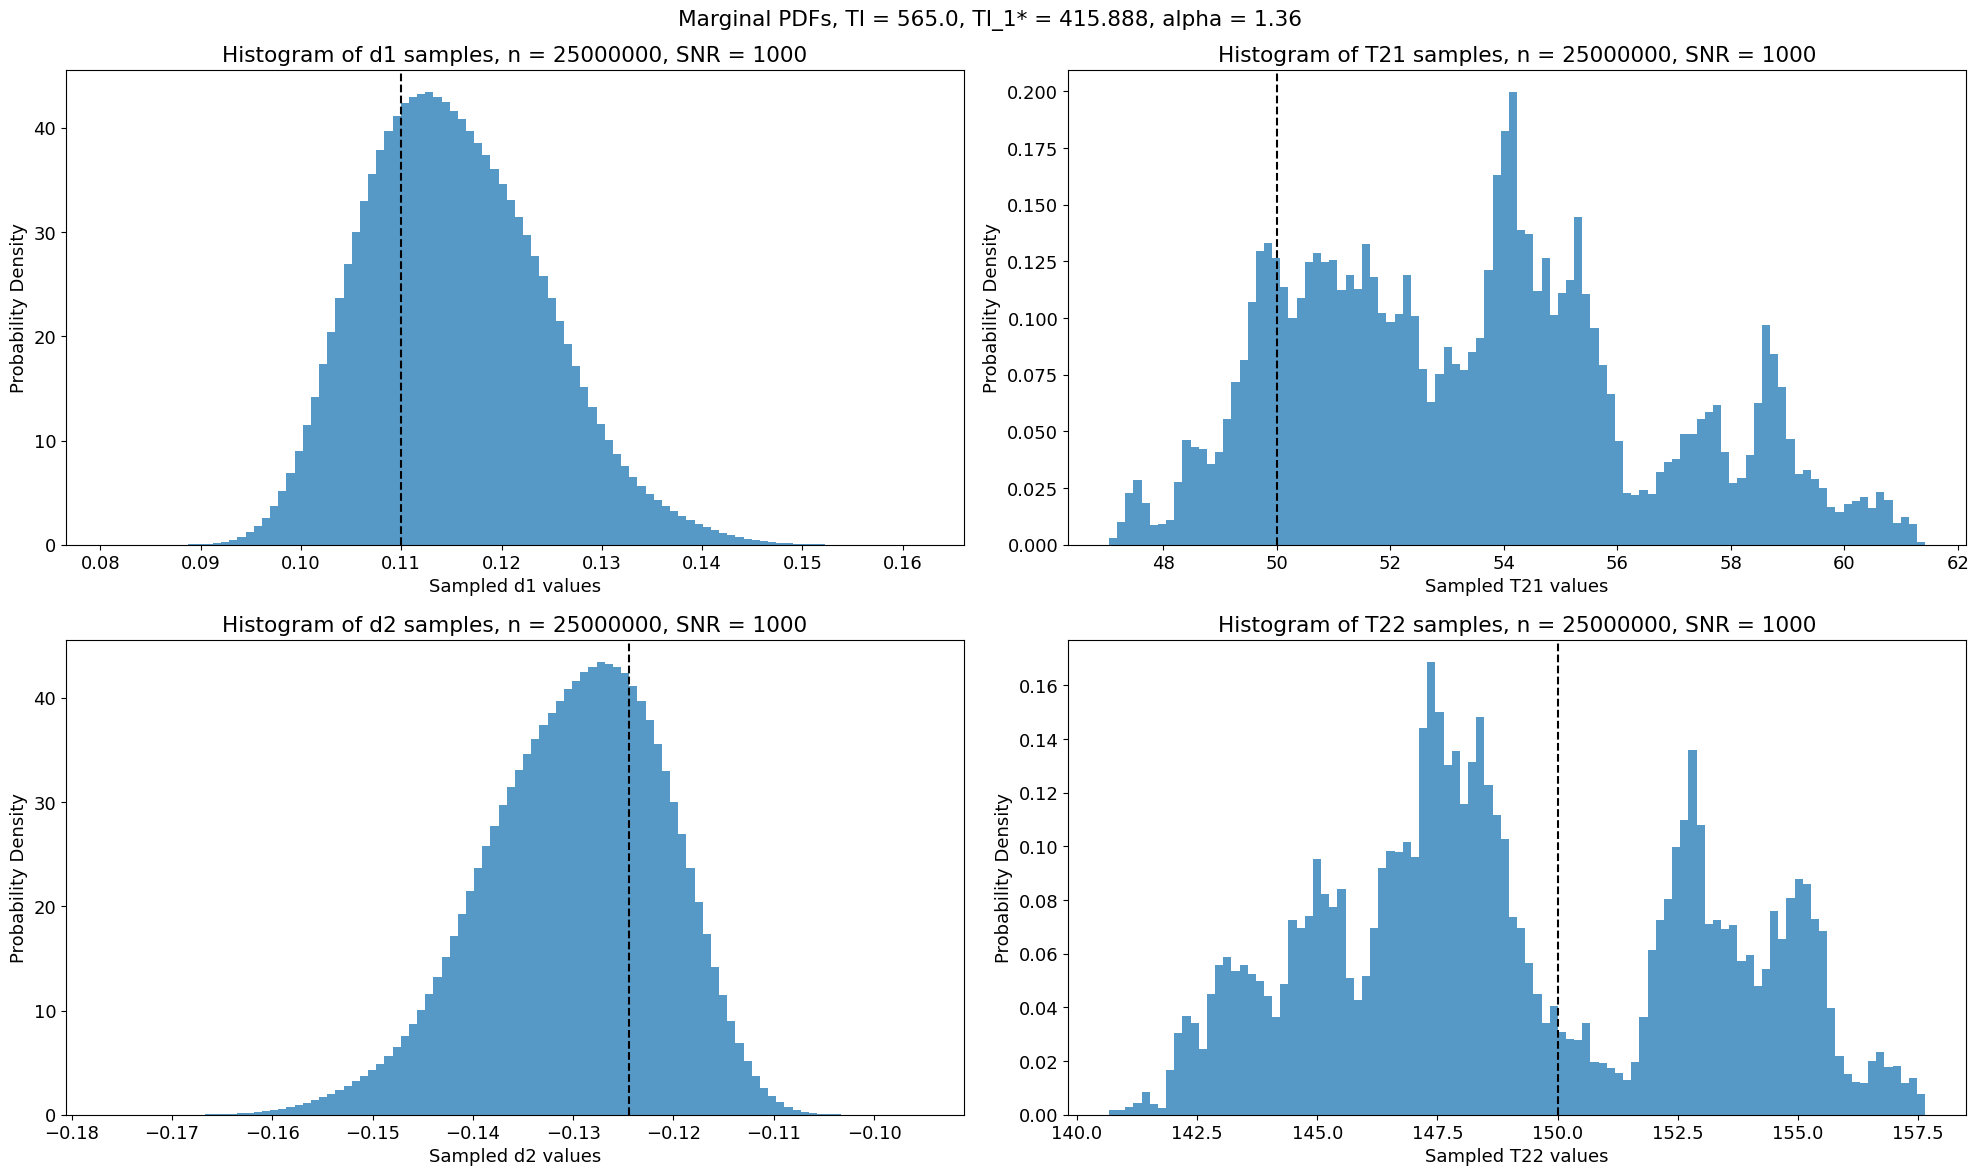

In [48]:
for i in range(hold_array.shape[0]):

    estimates_4p = hold_array[i,:,:]
    TI_temp = TI1_array[i]

    d1 = c1*(1-2*np.exp(-TI_temp/T11))
    d2 = c2*(1-2*np.exp(-TI_temp/T12))

    # print('Max of joint pdf at:', max_joint_pdf(estimates_4p)*np.array([1,1,t_norm,t_norm,t_norm,t_norm]))
    fig, ax = plt.subplots(2,2,figsize = (20, 12), tight_layout=True)
    plt.rc('font', size = 13)
    fig.suptitle(f'Marginal PDFs, TI = {TI_temp}, TI_1* = {np.round(TI1star,3)}, alpha = {np.round(TI_temp/TI1star,2)}')
    c1n, c1bins, c1patches = ax[0,0].hist(estimates_4p[:,0], 100, density=True, alpha=0.75)
    c1_estimate = c1bins[c1n.argmax()]
    print('d1 estimate:', c1_estimate)
    #ax[0,0].plot(c1_set, c1_function/integrate.simpson(c1_function, c1_set), label='Simpson Integration')
    ax[0,0].set_xlabel('Sampled d1 values')
    ax[0,0].set_ylabel('Probability Density')
    ax[0,0].axvline(x = d1, ls = '--', color = 'k', label = 'true d1')
    ax[0,0].set_title('Histogram of d1 samples, n = %s, SNR = %s' % (n_iter_m4p, SNR))

    c2n, c2bins, c2patches = ax[1,0].hist(estimates_4p[:,1], 100, density=True, alpha=0.75)
    c2_estimate = c2bins[c2n.argmax()]
    print('d2 estimate:', c2_estimate)
    ax[1,0].set_xlabel('Sampled d2 values')
    ax[1,0].set_ylabel('Probability Density')
    ax[1,0].axvline(x = d2, ls = '--', color = 'k', label = 'true d2')
    ax[1,0].set_title('Histogram of d2 samples, n = %s, SNR = %s' % (n_iter_m4p, SNR))

    T11n, T11bins, T11patches = ax[0,1].hist(estimates_4p[:,2], 100, density=True, alpha=0.75)
    T11_estimate = T11bins[T11n.argmax()]
    print('T21 estimate:', T11_estimate)
    ax[0,1].set_xlabel('Sampled T21 values')
    ax[0,1].set_ylabel('Probability Density')
    ax[0,1].axvline(x = T21, ls = '--', color = 'k', label = 'true T21')
    ax[0,1].set_title('Histogram of T21 samples, n = %s, SNR = %s' % (n_iter_m4p, SNR))

    T12n, T12bins, T12patches = ax[1,1].hist(estimates_4p[:,3], 100, density=True, alpha=0.75)
    T12_estimate = T12bins[T12n.argmax()]
    print('T22 estimate:', T12_estimate)
    ax[1,1].set_xlabel('Sampled T22 values')
    ax[1,1].set_ylabel('Probability Density')
    ax[1,1].axvline(x = T22, ls = '--', color = 'k', label = 'true T22')
    ax[1,1].set_title('Histogram of T22 samples, n = %s, SNR = %s' % (n_iter_m4p, SNR))

    plt.show()

In [58]:
norm_stdHold = np.zeros((hold_array.shape[0],4))
for i in range(hold_array.shape[0]):
    temp_mat = hold_array[i,:,:]
    avg_mat = np.mean(temp_mat, axis = 0, keepdims = True)
    assert(np.size(avg_mat)== temp_mat.shape[1])
    norm_mat = temp_mat/avg_mat
    std_mat = np.std(norm_mat, axis = 0)
    assert(np.size(std_mat)==4)
    norm_stdHold[i,:] = std_mat


Text(0, 0.5, 'std of the normal')

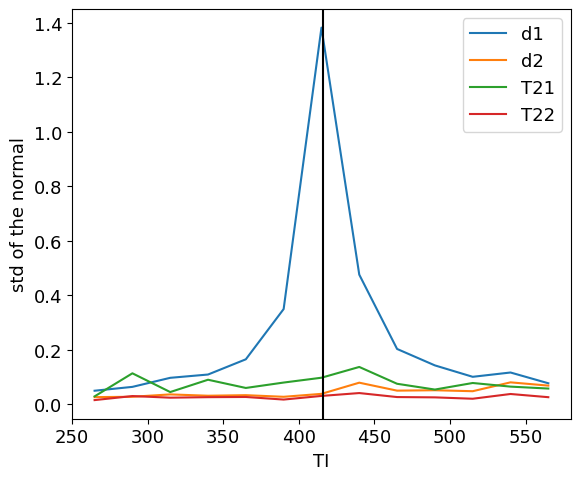

In [63]:
parameter_label = ('d1', 'd2', 'T21', 'T22')
plt.figure(figsize = (6, 5), tight_layout=True)
for i in range(norm_stdHold.shape[1]):
    plt.plot(TI1_array, norm_stdHold[:,i], label = parameter_label[i])
plt.xlabel('TI')
plt.axvline(x = TI1star, color = 'k')
plt.legend()
plt.ylabel('std of the normal')